# Reinforcement Learning Individual Assignment - Learning Text Flappy Bird

### Zhongke Sun - DSBA -M2

Colab Link:

https://colab.research.google.com/drive/1WuplAstOq4d_Sz7yGWNkcp6l_QYq9seq


## Environment and Gaming Setup

We will install the game environment and required libraries here.

In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git
!pip install scipy

  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to /private/var/folders/k3/g4lysjl52kxd09t9thyfryw40000gn/T/pip-req-build-po6jp8v5
  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git /private/var/folders/k3/g4lysjl52kxd09t9thyfryw40000gn/T/pip-req-build-po6jp8v5
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py) ... done


In [2]:
%matplotlib inline
import numpy as np
from scipy.stats import sem
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from numpy.random import randn
from IPython.display import clear_output
import os, sys
import gymnasium as gym
import time
import text_flappy_bird_gym
from tqdm import tqdm
import pickle
from collections import defaultdict
from mpl_toolkits.mplot3d import axes3d
from collections import deque

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import seaborn as sns
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Ensure the game running well in the environment

In [4]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
obs = env.reset()

# Iterate
while True:
    # Select next action
    action = env.action_space.sample() # for an agent, action = policy(observation)

    # Apply action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system('clear')
    sys.stdout.write(env.render())
    time.sleep(0.2)

    # If player is dead, break

    if done:
        break

env.close()



Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=12,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[                    ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Idle)
Distance From Pipe (dx=11,dy=3)
Text Flappy Bird!
Score: 0
----------------------
[       

## Agents

Here we will implement and compare two agents that can solve the TextFlappyBird. The first agent will be a Monte Carlo based agent (REINFORCE) and the second agent will be a Sarsa($\lambda$) agent

### Monte Carlo Based Agent (REINFORCE agent)

For summary, The **REINFORCE** algorithm ([Williams, 1992](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf)) is a monte carlo variation of policy gradient algorithm in RL. The agent collects the trajectory of an episode from current policy. Usually, this policy depends on the policy parameter which denoted as $\theta$. Actually, REINFORCE is acronym for "**RE**ward **I**ncrement = **N**onnegative **F**actor * **O**ffset **R**einforcement * **C**haracteristic **E**ligibility"


The first input of the REINFORCE is a policy.

#### Policy

In [5]:
class REINFORCE_Agent(nn.Module):
    def __init__(self, state_size=2, action_size=2, hidden_size=128):
        super(REINFORCE_Agent, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

#### REINFORCEMENT Training

In [6]:
def reinforce_training(n_episodes, policy, optimizer, gamma=1.0, window_size=50):
    scores_deque = deque(maxlen=window_size)
    scores = []
    state_values = defaultdict(list)
    for e in tqdm(range(1, n_episodes + 1), desc='Training REINFORCE'):
        saved_log_probs = []
        rewards = []
        states = []
        state, _ = env.reset()

        # Collect trajectory
        while True:
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob.to(device))

            # Take action
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            states.append(state)
            rewards.append(reward)
            state = next_state

            if done:
                break


        returns = []
        G = 0
        for r in reversed(rewards):
            G = r + gamma * G
            returns.insert(0, G)

        returns = torch.tensor(returns, dtype=torch.float32).to(device)
        returns = (returns - returns.mean()) / (returns.std() + 1e-9)  # Normalization

        # Computer Loss
        policy_loss = [-log_prob * Gt for log_prob, Gt in zip(saved_log_probs, returns)]
        policy_loss = torch.stack(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        # Store state-value estimates
        for s, Gt in zip(states, returns.cpu().numpy()):
            state_values[tuple(s)].append(Gt)

        total_reward = sum(rewards)
        scores.append(total_reward)
        scores_deque.append(total_reward)

        if e % 250 == 0:
            print(f'Episode {e} \tRecent Smoothed Score: {np.mean(scores_deque):.2f}')

    return scores, state_values

### SARSA Agent ($\lambda$)

SARSA (State-Action-Reward-State-Action) is an on-policy reinforcement learning algorithm that updates Q-value based on the agent's actual experiences, including exploratory actions.

The key hyperparameters are the learning rate ($\alpha$), discount factor ($\gamma$), and exploration rate ($\epsilon$). They control the speed of learning, the important of future rewards, and the balance between exploration and exploitation, respectively.

#### Policy

In [7]:
class Sarsa_Policy(nn.Module):
    def __init__(self, state_size=2, action_size=2, hidden_size=128):
        super(Sarsa_Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        return self.fc2(x)  # Output Q(s, a)

    def act(self, state, epsilon=0.1):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        q_values = self.forward(state).cpu().detach().numpy()[0]  # Compute Q value

        if np.random.rand() < epsilon:
            return np.random.choice(len(q_values))  # Randomly take actions
        return np.argmax(q_values)  # Choose the action with the biggest Q value

In [8]:
class Sarsa_Agent:
    def __init__(self, policy, optimizer, params):
        self.policy = policy
        self.optimizer = optimizer
        self.gamma = params["gamma"]
        self.lambda_ = params["lambda_"]
        self.epsilon = params["epsilon"]
        self.epsilon_decay = params["epsilon_decay"]
        self.min_epsilon = params["min_epsilon"]

    def act(self, state):
        return self.policy.act(state, self.epsilon)

    def update(self, state, action, reward, next_state, next_action, done):
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        next_state_tensor = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0).to(device)

        q_values = self.policy(state_tensor)
        next_q_values = self.policy(next_state_tensor)

        # Calculate target Q vaule
        target = reward + (1 - done) * self.gamma * next_q_values[0, next_action]
        loss = F.mse_loss(q_values[0, action], target.detach())  # Calculate MSE loss

        # Backward optimization
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Reduce epsilon step by step，Reduce exploration
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

#### SARSA Agent Training

In [9]:
def sarsa_training(n_episodes, policy, optimizer, params, print_every=250, window_size=50):
    agent = Sarsa_Agent(policy, optimizer, params)
    scores = []
    scores_deque = deque(maxlen=window_size)
    state_values = defaultdict(list)

    for e in tqdm(range(1, n_episodes + 1), desc='Training SARSA(λ)'):
        state, _ = env.reset()
        action = agent.act(state)
        total_reward = 0
        episode_states = []

        while True:
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_action = agent.act(next_state)
            agent.update(state, action, reward, next_state, next_action, done)

            episode_states.append(state)
            state, action = next_state, next_action
            total_reward += reward

            if done:
                break

        scores.append(total_reward)
        scores_deque.append(total_reward)
        
        # Store state-value estimates
        for s in episode_states:
            s = tuple(s)
            if s in state_values:
                state_values[s].append(total_reward)  # Approximate V(s) with episode returns
            else:
                state_values[s] = [total_reward]

        if e % print_every == 0:
            print(f'Episode {e} \tRecent Smoothed Score: {np.mean(scores_deque):.2f}')

    return scores, state_values

## Hyperparameter Tuning

Here I will do investigation on how the two implemented agents differ. I will conduct experiments based on 4 features:

- Sensitivity to parameters: Normalized Sensitivity Coefficient (NSC).

$$\text{NSC} = \frac{\Delta R}{\Delta P} \times \frac{P_{\text{mean}}}{R_{\text{mean}}}$$

- Convergence time: The first episode where the moving average of the last 'window_size' episodes is greater than or equal to 'threshold'.
- Rewards
- Scores

### Experimental Setup:

**Environment:**
- env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
- Epochs: 1000 for REINFORCE agent and 1500 for SARSA agent. (Because there are a lot of parameters to test, 1000 epochs are enough for REINFORCE agent to converge and determine the optimal parameters. But SARSA agent needs 500 epochs more).


**Base Parameters:**

- REINFORCE
    - Gamma: 0.99
    - Learning rate: 5e-4

- SARSA
    - Alpha: 0.1
    - Alpha decay: 0.995
    - Action_size: 2
    - Gamma: 0.99
    - Lambda_: 0.9
    - epsilon: 1.0
    - epsilon_decay: 0.997
    - min_epsilon: 0.01
    - Learning rate: 5e-4


**Parameters Grid:**

- REINFORCE
    - Gamma: [0.8, 0.9, 0.95, 0.99, 1.0]
    - Learning rate: [1e-3, 5e-4, 1e-4, 1e-5]

- SARSA
    - Alpha: [0.01, 0.05, 0.1]
    - Alpha decay: [0.99, 0.995, 0.999]
    - Action_size: 2
    - Gamma: [0.8, 0.9, 0.95, 0.99, 1.0]
    - Lambda_: [0.1, 0.2, 0.5, 0.8, 0.9, 0.99]
    - epsilon: [1.0, 0.5, 0.1]
    - epsilon_decay: [0.99, 0.995, 0.999]
    - min_epsilon: [0.01, 0.05, 0.1]
    - Learning rate: [1e-3, 5e-4, 1e-4, 1e-5]

In [10]:
def compute_convergence_time(scores, threshold, window_size=50):
    """
    Compute convergence time: Find the first episode where the moving average
    of the last 'window_size' episodes is greater than or equal to 'threshold'.
    """
    scores_deque = deque(maxlen=window_size)

    for i, score in enumerate(scores):
        scores_deque.append(score)
        if len(scores_deque) == window_size and np.mean(scores_deque) >= threshold:
            return i + 1  # Return the current episode number

    return len(scores)  # If the threshold is never reached, return the max episode count

In [11]:
def compute_sensitivity(param_grid, avg_rewards, avg_scores):
    """
    Compute Normalized Sensitivity Coefficient (NSC)
    """
    sensitivity_rewards = {}
    sensitivity_scores = {}

    for param_name, values in param_grid.items():
        rewards = []
        scores = []
        params = []

        for value in values:
            if (param_name, value) in avg_rewards:
                rewards.append(avg_rewards[(param_name, value)])
                scores.append(avg_scores[(param_name, value)])
                params.append(value)

        if len(params) > 1:
            delta_rewards = np.diff(rewards)
            delta_scores = np.diff(scores)
            delta_params = np.diff(params)

            reward_mean = np.mean(rewards)
            score_mean = np.mean(scores)
            param_mean = np.mean(params)

            sensitivity_rewards[param_name] = np.mean((delta_rewards / delta_params) * (param_mean / reward_mean))
            sensitivity_scores[param_name] = np.mean((delta_scores / delta_params) * (param_mean / score_mean))

    return sensitivity_rewards, sensitivity_scores

In [ ]:
def test_reinforce_sensitivity(param_grid, base_params, n_episodes=1000, threshold=100, window_size=50):
    """
    Conduct sensitivity analysis for REINFORCE (gamma, learning rate)
    """
    results = {}  # Training results
    convergence_times = {}  # Convergence time
    avg_rewards = {}  # Average rewards
    avg_scores = {}  # Final scores
    state_values_all = {}  # Store all state-value function results

    for param_name, values in param_grid.items():
        for value in values:
            params = base_params.copy()
            params[param_name] = value

            print(f"\nTesting {param_name} = {value}...\n")

            # Train REINFORCE agent
            policy = REINFORCE_Agent().to(device)
            optimizer = optim.Adam(policy.parameters(), lr=params["lr"])
            scores, state_values = reinforce_training(n_episodes, policy, optimizer, gamma=params["gamma"])

            if not isinstance(scores, list):
                scores = list(scores)

            print("Processed Scores:", type(scores), len(scores))  # Debugging info

            convergence_time = compute_convergence_time(scores, threshold)
            avg_reward = np.mean(scores)  # Compute the average reward of Episodes
            avg_score = np.mean(scores[-window_size:])

            # Store the result
            results[(param_name, value)] = scores
            convergence_times[(param_name, value)] = convergence_time
            avg_rewards[(param_name, value)] = avg_reward
            avg_scores[(param_name, value)] = avg_score
            state_values_all[(param_name, value)] = state_values  # Store state-values

    return results, convergence_times, avg_rewards, avg_scores, state_values_all

def test_sarsa_sensitivity(param_grid, base_params, n_episodes=1500, threshold=100, window_size=50):
    """
    Conduct sensitivity analysis for SARSA(λ) (gamma, lr, epsilon, epsilon_decay, alpha, alpha_decay, lambda)
    """
    results = {}  # Training results
    convergence_times = {}  # Convergence time
    avg_rewards = {}  # Average rewards
    avg_scores = {}  # Final scores
    state_values_all = {}  # Store all state-value function results

    for param_name, values in param_grid.items():
        for value in values:
            params = base_params.copy()
            params[param_name] = value

            print(f"\nTesting {param_name} = {value}...\n")

            # Train SARSA agent
            policy = Sarsa_Policy().to(device)
            optimizer = optim.Adam(policy.parameters(), lr=params["lr"])
            result = sarsa_training(n_episodes, policy, optimizer, params)

            # Ensure return with (scores, state_values)
            if isinstance(result, tuple) and len(result) == 2:
                scores, state_values = result
            else:
                raise ValueError(f"Unexpected return value from sarsa_training(): {type(result)}")

            # Ensure scores is a list
            if not isinstance(scores, list):
                scores = list(scores)

            print("Processed Scores:", type(scores), len(scores))  # Debugging info

            convergence_time = compute_convergence_time(scores, threshold)
            avg_reward = np.mean(scores)  # Calculate the average reward of all Episodes
            avg_score = np.mean(scores[-window_size:])  # Calculate average scores of recent window_size episodes

            # Store the result
            results[(param_name, value)] = scores
            convergence_times[(param_name, value)] = convergence_time
            avg_rewards[(param_name, value)] = avg_reward
            avg_scores[(param_name, value)] = avg_score
            state_values_all[(param_name, value)] = state_values  # Store state-values

    return results, convergence_times, avg_rewards, avg_scores, state_values_all

## Hyperparameters Tuning

Start train the agent with different combinations of parameters.

### ATTENTION ! ! ! : 

##### For REINFORCE agent, please ignore the experiments with different parameters excluding **learning rate \& $\gamma$**. They are unrelevant for REINFORCE method, here just for easy functioning.

In [13]:
# 1. Set Base Parameters
base_params_reinforce = {
    "gamma": 0.99,
    "lr": 5e-4
}

base_params_sarsa = {
    "gamma": 0.99,
    "lambda_": 0.9,
    "epsilon": 1.0,
    "epsilon_decay": 0.997,
    "min_epsilon": 0.01,
    "alpha": 0.1,
    "alpha_decay": 0.995,
    "lr": 5e-4
}

# 2. Define Test Parameters
param_grid_reinforce = {
    "gamma": [0.8, 0.9, 0.95, 0.99, 1.0],  
    "lr": [1e-3, 5e-4, 1e-4, 1e-5]  
}

param_grid_sarsa = {
    "gamma": [0.8, 0.9, 0.95, 0.99, 1.0],  
    "lambda_": [0.1, 0.2, 0.5, 0.8, 0.9, 0.99],  
    "epsilon": [1.0, 0.5, 0.1],  
    "epsilon_decay": [0.99, 0.995, 0.999],  
    "min_epsilon": [0.01, 0.05, 0.1],  
    "alpha": [0.01, 0.05, 0.1],  
    "alpha_decay": [0.99, 0.995, 0.999],  
    "lr": [1e-3, 5e-4, 1e-4, 1e-5]  
}

In [14]:
env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

reinforce_results, reinforce_convergence_times, reinforce_avg_rewards, reinforce_avg_scores, reinforce_state_values = test_reinforce_sensitivity(param_grid_reinforce, base_params_reinforce, n_episodes=1000)

sarsa_results, sarsa_convergence_times, sarsa_avg_rewards, sarsa_avg_scores, sarsa_state_values = test_sarsa_sensitivity(param_grid_sarsa, base_params_sarsa, n_episodes=1500)


Testing gamma = 0.8...



Training REINFORCE:  26%|██▌       | 262/1000 [00:02<00:07, 96.22it/s] 

Episode 250 	Recent Smoothed Score: 48.70


Training REINFORCE:  50%|█████     | 504/1000 [00:07<00:10, 46.04it/s]

Episode 500 	Recent Smoothed Score: 86.44


Training REINFORCE:  75%|███████▌  | 750/1000 [00:27<00:53,  4.66it/s]

Episode 750 	Recent Smoothed Score: 636.58


Training REINFORCE: 100%|██████████| 1000/1000 [02:36<00:00,  6.38it/s]


Episode 1000 	Recent Smoothed Score: 3743.80
Processed Scores: <class 'list'> 1000

Testing gamma = 0.9...



Training REINFORCE:  27%|██▋       | 267/1000 [00:01<00:04, 148.36it/s]

Episode 250 	Recent Smoothed Score: 32.60


Training REINFORCE:  51%|█████     | 512/1000 [00:04<00:05, 81.98it/s] 

Episode 500 	Recent Smoothed Score: 65.36


Training REINFORCE:  75%|███████▌  | 751/1000 [00:11<00:11, 22.35it/s]

Episode 750 	Recent Smoothed Score: 176.22


Training REINFORCE: 100%|██████████| 1000/1000 [00:43<00:00, 22.99it/s]


Episode 1000 	Recent Smoothed Score: 1273.40
Processed Scores: <class 'list'> 1000

Testing gamma = 0.95...



Training REINFORCE:  31%|███       | 312/1000 [00:01<00:02, 325.22it/s]

Episode 250 	Recent Smoothed Score: 13.00


Training REINFORCE:  55%|█████▍    | 548/1000 [00:01<00:01, 330.51it/s]

Episode 500 	Recent Smoothed Score: 13.00


Training REINFORCE:  78%|███████▊  | 780/1000 [00:02<00:00, 322.64it/s]

Episode 750 	Recent Smoothed Score: 13.20


Training REINFORCE: 100%|██████████| 1000/1000 [00:04<00:00, 233.99it/s]


Episode 1000 	Recent Smoothed Score: 49.72
Processed Scores: <class 'list'> 1000

Testing gamma = 0.99...



Training REINFORCE:  29%|██▉       | 292/1000 [00:01<00:02, 246.24it/s]

Episode 250 	Recent Smoothed Score: 16.18


Training REINFORCE:  51%|█████     | 508/1000 [00:03<00:06, 78.88it/s] 

Episode 500 	Recent Smoothed Score: 67.86


Training REINFORCE:  76%|███████▋  | 763/1000 [00:07<00:04, 55.58it/s]

Episode 750 	Recent Smoothed Score: 94.08


Training REINFORCE: 100%|██████████| 1000/1000 [00:13<00:00, 72.54it/s]


Episode 1000 	Recent Smoothed Score: 129.80
Processed Scores: <class 'list'> 1000

Testing gamma = 1.0...



Training REINFORCE:  26%|██▌       | 258/1000 [00:01<00:07, 105.72it/s]

Episode 250 	Recent Smoothed Score: 40.48


Training REINFORCE:  51%|█████     | 508/1000 [00:04<00:06, 70.86it/s] 

Episode 500 	Recent Smoothed Score: 66.40


Training REINFORCE:  76%|███████▌  | 755/1000 [00:09<00:04, 58.53it/s]

Episode 750 	Recent Smoothed Score: 79.04


Training REINFORCE: 100%|██████████| 1000/1000 [00:16<00:00, 59.08it/s]


Episode 1000 	Recent Smoothed Score: 213.46
Processed Scores: <class 'list'> 1000

Testing lr = 0.001...



Training REINFORCE:  26%|██▋       | 263/1000 [00:01<00:07, 94.26it/s] 

Episode 250 	Recent Smoothed Score: 49.42


Training REINFORCE:  50%|█████     | 502/1000 [00:05<00:11, 43.99it/s]

Episode 500 	Recent Smoothed Score: 98.98


Training REINFORCE:  75%|███████▌  | 751/1000 [00:21<00:53,  4.67it/s]

Episode 750 	Recent Smoothed Score: 665.94


Training REINFORCE: 100%|██████████| 1000/1000 [03:20<00:00,  4.98it/s]


Episode 1000 	Recent Smoothed Score: 5136.60
Processed Scores: <class 'list'> 1000

Testing lr = 0.0005...



Training REINFORCE:  26%|██▌       | 261/1000 [00:01<00:05, 138.22it/s]

Episode 250 	Recent Smoothed Score: 34.46


Training REINFORCE:  51%|█████     | 511/1000 [00:04<00:04, 107.06it/s]

Episode 500 	Recent Smoothed Score: 45.08


Training REINFORCE:  76%|███████▌  | 760/1000 [00:07<00:04, 56.30it/s] 

Episode 750 	Recent Smoothed Score: 90.34


Training REINFORCE: 100%|██████████| 1000/1000 [00:15<00:00, 64.43it/s]


Episode 1000 	Recent Smoothed Score: 174.92
Processed Scores: <class 'list'> 1000

Testing lr = 0.0001...



Training REINFORCE:  30%|██▉       | 298/1000 [00:00<00:02, 278.66it/s]

Episode 250 	Recent Smoothed Score: 17.30


Training REINFORCE:  54%|█████▎    | 537/1000 [00:01<00:01, 245.25it/s]

Episode 500 	Recent Smoothed Score: 19.30


Training REINFORCE:  78%|███████▊  | 782/1000 [00:03<00:01, 201.51it/s]

Episode 750 	Recent Smoothed Score: 20.84


Training REINFORCE: 100%|██████████| 1000/1000 [00:04<00:00, 230.64it/s]


Episode 1000 	Recent Smoothed Score: 31.86
Processed Scores: <class 'list'> 1000

Testing lr = 1e-05...



Training REINFORCE:  29%|██▉       | 290/1000 [00:01<00:03, 221.99it/s]

Episode 250 	Recent Smoothed Score: 18.80


Training REINFORCE:  54%|█████▍    | 540/1000 [00:02<00:02, 212.66it/s]

Episode 500 	Recent Smoothed Score: 21.68


Training REINFORCE:  79%|███████▉  | 788/1000 [00:03<00:01, 192.06it/s]

Episode 750 	Recent Smoothed Score: 22.10


Training REINFORCE: 100%|██████████| 1000/1000 [00:04<00:00, 201.71it/s]


Episode 1000 	Recent Smoothed Score: 24.28
Processed Scores: <class 'list'> 1000

Testing gamma = 0.8...



Training SARSA(λ):  19%|█▊        | 281/1500 [00:01<00:04, 246.16it/s]

Episode 250 	Recent Smoothed Score: 14.40


Training SARSA(λ):  36%|███▌      | 536/1500 [00:02<00:04, 200.89it/s]

Episode 500 	Recent Smoothed Score: 16.00


Training SARSA(λ):  51%|█████     | 768/1500 [00:04<00:07, 104.42it/s]

Episode 750 	Recent Smoothed Score: 34.40


Training SARSA(λ):  68%|██████▊   | 1025/1500 [00:06<00:03, 126.81it/s]

Episode 1000 	Recent Smoothed Score: 27.40


Training SARSA(λ):  85%|████████▍ | 1269/1500 [00:08<00:02, 109.76it/s]

Episode 1250 	Recent Smoothed Score: 29.02


Training SARSA(λ): 100%|██████████| 1500/1500 [00:10<00:00, 143.54it/s]


Episode 1500 	Recent Smoothed Score: 34.00
Processed Scores: <class 'list'> 1500

Testing gamma = 0.9...



Training SARSA(λ):  20%|█▉        | 298/1500 [00:01<00:05, 217.32it/s]

Episode 250 	Recent Smoothed Score: 21.32


Training SARSA(λ):  36%|███▌      | 536/1500 [00:02<00:03, 247.67it/s]

Episode 500 	Recent Smoothed Score: 13.20


Training SARSA(λ):  52%|█████▏    | 776/1500 [00:05<00:10, 66.45it/s] 

Episode 750 	Recent Smoothed Score: 101.20


Training SARSA(λ):  67%|██████▋   | 1003/1500 [00:14<00:25, 19.84it/s]

Episode 1000 	Recent Smoothed Score: 171.68


Training SARSA(λ):  83%|████████▎ | 1252/1500 [00:25<00:08, 29.30it/s]

Episode 1250 	Recent Smoothed Score: 217.62


Training SARSA(λ): 100%|██████████| 1500/1500 [00:36<00:00, 40.87it/s]


Episode 1500 	Recent Smoothed Score: 110.90
Processed Scores: <class 'list'> 1500

Testing gamma = 0.95...



Training SARSA(λ):  20%|█▉        | 299/1500 [00:01<00:04, 263.80it/s]

Episode 250 	Recent Smoothed Score: 13.02


Training SARSA(λ):  35%|███▌      | 526/1500 [00:02<00:04, 225.65it/s]

Episode 500 	Recent Smoothed Score: 15.02


Training SARSA(λ):  51%|█████     | 765/1500 [00:03<00:04, 147.72it/s]

Episode 750 	Recent Smoothed Score: 25.20


Training SARSA(λ):  67%|██████▋   | 1009/1500 [00:05<00:04, 112.74it/s]

Episode 1000 	Recent Smoothed Score: 32.10


Training SARSA(λ):  84%|████████▍ | 1258/1500 [00:08<00:02, 115.33it/s]

Episode 1250 	Recent Smoothed Score: 27.68


Training SARSA(λ): 100%|██████████| 1500/1500 [00:10<00:00, 140.48it/s]


Episode 1500 	Recent Smoothed Score: 33.22
Processed Scores: <class 'list'> 1500

Testing gamma = 0.99...



Training SARSA(λ):  19%|█▊        | 278/1500 [00:01<00:05, 208.41it/s]

Episode 250 	Recent Smoothed Score: 17.22


Training SARSA(λ):  34%|███▍      | 513/1500 [00:02<00:08, 113.34it/s]

Episode 500 	Recent Smoothed Score: 33.26


Training SARSA(λ):  51%|█████▏    | 772/1500 [00:04<00:05, 135.64it/s]

Episode 750 	Recent Smoothed Score: 28.40


Training SARSA(λ):  67%|██████▋   | 1005/1500 [00:07<00:07, 66.33it/s]

Episode 1000 	Recent Smoothed Score: 52.14


Training SARSA(λ):  83%|████████▎ | 1250/1500 [00:17<00:26,  9.32it/s]

Episode 1250 	Recent Smoothed Score: 387.96


Training SARSA(λ): 100%|██████████| 1500/1500 [01:14<00:00, 20.19it/s]


Episode 1500 	Recent Smoothed Score: 931.10
Processed Scores: <class 'list'> 1500

Testing gamma = 1.0...



Training SARSA(λ):  19%|█▊        | 278/1500 [00:01<00:04, 257.75it/s]

Episode 250 	Recent Smoothed Score: 13.72


Training SARSA(λ):  35%|███▌      | 529/1500 [00:02<00:05, 180.73it/s]

Episode 500 	Recent Smoothed Score: 20.20


Training SARSA(λ):  51%|█████     | 768/1500 [00:04<00:06, 119.07it/s]

Episode 750 	Recent Smoothed Score: 31.20


Training SARSA(λ):  69%|██████▊   | 1028/1500 [00:06<00:03, 133.84it/s]

Episode 1000 	Recent Smoothed Score: 28.40


Training SARSA(λ):  84%|████████▍ | 1261/1500 [00:09<00:02, 79.95it/s] 

Episode 1250 	Recent Smoothed Score: 54.36


Training SARSA(λ): 100%|██████████| 1500/1500 [00:11<00:00, 127.49it/s]


Episode 1500 	Recent Smoothed Score: 42.00
Processed Scores: <class 'list'> 1500

Testing lambda_ = 0.1...



Training SARSA(λ):  18%|█▊        | 275/1500 [00:01<00:05, 220.09it/s]

Episode 250 	Recent Smoothed Score: 15.12


Training SARSA(λ):  35%|███▍      | 520/1500 [00:02<00:07, 136.05it/s]

Episode 500 	Recent Smoothed Score: 29.50


Training SARSA(λ):  51%|█████     | 758/1500 [00:04<00:06, 107.69it/s]

Episode 750 	Recent Smoothed Score: 33.84


Training SARSA(λ):  67%|██████▋   | 1002/1500 [00:09<00:17, 28.97it/s]

Episode 1000 	Recent Smoothed Score: 99.98


Training SARSA(λ):  83%|████████▎ | 1250/1500 [00:52<01:00,  4.12it/s]

Episode 1250 	Recent Smoothed Score: 782.56


Training SARSA(λ): 100%|██████████| 1500/1500 [01:49<00:00, 13.69it/s]


Episode 1500 	Recent Smoothed Score: 818.08
Processed Scores: <class 'list'> 1500

Testing lambda_ = 0.2...



Training SARSA(λ):  19%|█▉        | 289/1500 [00:01<00:06, 188.49it/s]

Episode 250 	Recent Smoothed Score: 27.30


Training SARSA(λ):  34%|███▍      | 507/1500 [00:02<00:06, 160.58it/s]

Episode 500 	Recent Smoothed Score: 29.74


Training SARSA(λ):  50%|█████     | 753/1500 [00:08<00:09, 82.81it/s] 

Episode 750 	Recent Smoothed Score: 13.16


Training SARSA(λ):  67%|██████▋   | 998/1500 [00:49<02:11,  3.81it/s]

Episode 1000 	Recent Smoothed Score: 770.56


Training SARSA(λ):  83%|████████▎ | 1252/1500 [01:38<00:48,  5.10it/s]

Episode 1250 	Recent Smoothed Score: 744.52


Training SARSA(λ): 100%|██████████| 1500/1500 [02:25<00:00, 10.28it/s]


Episode 1500 	Recent Smoothed Score: 686.84
Processed Scores: <class 'list'> 1500

Testing lambda_ = 0.5...



Training SARSA(λ):  18%|█▊        | 277/1500 [00:01<00:06, 183.76it/s]

Episode 250 	Recent Smoothed Score: 18.60


Training SARSA(λ):  34%|███▍      | 516/1500 [00:02<00:06, 150.28it/s]

Episode 500 	Recent Smoothed Score: 23.68


Training SARSA(λ):  50%|█████     | 753/1500 [00:05<00:11, 65.33it/s] 

Episode 750 	Recent Smoothed Score: 56.92


Training SARSA(λ):  67%|██████▋   | 1000/1500 [00:14<00:38, 12.87it/s]

Episode 1000 	Recent Smoothed Score: 205.04


Training SARSA(λ):  83%|████████▎ | 1249/1500 [00:52<00:46,  5.40it/s]

Episode 1250 	Recent Smoothed Score: 737.68


Training SARSA(λ): 100%|██████████| 1500/1500 [01:45<00:00, 14.22it/s]


Episode 1500 	Recent Smoothed Score: 671.50
Processed Scores: <class 'list'> 1500

Testing lambda_ = 0.8...



Training SARSA(λ):  18%|█▊        | 265/1500 [00:01<00:07, 156.24it/s]

Episode 250 	Recent Smoothed Score: 24.28


Training SARSA(λ):  34%|███▍      | 513/1500 [00:05<00:12, 76.75it/s] 

Episode 500 	Recent Smoothed Score: 79.22


Training SARSA(λ):  50%|████▉     | 748/1500 [00:18<04:57,  2.53it/s]

Episode 750 	Recent Smoothed Score: 668.36


Training SARSA(λ):  67%|██████▋   | 1000/1500 [01:14<02:37,  3.17it/s]

Episode 1000 	Recent Smoothed Score: 826.46


Training SARSA(λ):  83%|████████▎ | 1250/1500 [02:12<01:11,  3.49it/s]

Episode 1250 	Recent Smoothed Score: 800.86


Training SARSA(λ): 100%|██████████| 1500/1500 [03:09<00:00,  7.90it/s]


Episode 1500 	Recent Smoothed Score: 938.12
Processed Scores: <class 'list'> 1500

Testing lambda_ = 0.9...



Training SARSA(λ):  20%|█▉        | 297/1500 [00:01<00:04, 245.50it/s]

Episode 250 	Recent Smoothed Score: 15.72


Training SARSA(λ):  35%|███▌      | 531/1500 [00:02<00:05, 178.64it/s]

Episode 500 	Recent Smoothed Score: 17.86


Training SARSA(λ):  52%|█████▏    | 775/1500 [00:03<00:03, 215.39it/s]

Episode 750 	Recent Smoothed Score: 13.60


Training SARSA(λ):  67%|██████▋   | 1008/1500 [00:05<00:04, 121.81it/s]

Episode 1000 	Recent Smoothed Score: 33.18


Training SARSA(λ):  83%|████████▎ | 1252/1500 [00:09<00:03, 77.78it/s] 

Episode 1250 	Recent Smoothed Score: 23.86


Training SARSA(λ): 100%|██████████| 1500/1500 [00:41<00:00, 36.34it/s]


Episode 1500 	Recent Smoothed Score: 925.96
Processed Scores: <class 'list'> 1500

Testing lambda_ = 0.99...



Training SARSA(λ):  18%|█▊        | 277/1500 [00:01<00:05, 243.82it/s]

Episode 250 	Recent Smoothed Score: 14.18


Training SARSA(λ):  36%|███▌      | 533/1500 [00:02<00:04, 199.40it/s]

Episode 500 	Recent Smoothed Score: 16.20


Training SARSA(λ):  51%|█████     | 767/1500 [00:03<00:03, 219.62it/s]

Episode 750 	Recent Smoothed Score: 13.80


Training SARSA(λ):  67%|██████▋   | 1012/1500 [00:05<00:04, 103.86it/s]

Episode 1000 	Recent Smoothed Score: 37.32


Training SARSA(λ):  83%|████████▎ | 1246/1500 [00:12<00:15, 16.01it/s] 

Episode 1250 	Recent Smoothed Score: 198.66


Training SARSA(λ): 100%|██████████| 1500/1500 [01:13<00:00, 20.39it/s]


Episode 1500 	Recent Smoothed Score: 1003.56
Processed Scores: <class 'list'> 1500

Testing epsilon = 1.0...



Training SARSA(λ):  19%|█▉        | 286/1500 [00:01<00:04, 257.45it/s]

Episode 250 	Recent Smoothed Score: 13.00


Training SARSA(λ):  35%|███▌      | 526/1500 [00:02<00:03, 249.49it/s]

Episode 500 	Recent Smoothed Score: 12.82


Training SARSA(λ):  53%|█████▎    | 788/1500 [00:03<00:02, 255.56it/s]

Episode 750 	Recent Smoothed Score: 13.20


Training SARSA(λ):  69%|██████▊   | 1031/1500 [00:04<00:02, 213.56it/s]

Episode 1000 	Recent Smoothed Score: 16.20


Training SARSA(λ):  85%|████████▍ | 1273/1500 [00:05<00:01, 162.63it/s]

Episode 1250 	Recent Smoothed Score: 21.00


Training SARSA(λ): 100%|██████████| 1500/1500 [00:07<00:00, 207.95it/s]


Episode 1500 	Recent Smoothed Score: 31.20
Processed Scores: <class 'list'> 1500

Testing epsilon = 0.5...



Training SARSA(λ):  19%|█▉        | 282/1500 [00:01<00:05, 210.19it/s]

Episode 250 	Recent Smoothed Score: 15.40


Training SARSA(λ):  34%|███▍      | 507/1500 [00:02<00:06, 143.67it/s]

Episode 500 	Recent Smoothed Score: 27.18


Training SARSA(λ):  50%|█████     | 755/1500 [00:04<00:03, 204.70it/s]

Episode 750 	Recent Smoothed Score: 13.80


Training SARSA(λ):  67%|██████▋   | 1005/1500 [00:08<00:13, 36.37it/s]

Episode 1000 	Recent Smoothed Score: 93.34


Training SARSA(λ):  83%|████████▎ | 1250/1500 [00:28<00:14, 17.75it/s]

Episode 1250 	Recent Smoothed Score: 517.02


Training SARSA(λ): 100%|██████████| 1500/1500 [01:21<00:00, 18.46it/s]


Episode 1500 	Recent Smoothed Score: 845.84
Processed Scores: <class 'list'> 1500

Testing epsilon = 0.1...



Training SARSA(λ):  19%|█▉        | 285/1500 [00:01<00:05, 205.63it/s]

Episode 250 	Recent Smoothed Score: 16.60


Training SARSA(λ):  34%|███▍      | 509/1500 [00:03<00:08, 114.15it/s]

Episode 500 	Recent Smoothed Score: 26.32


Training SARSA(λ):  50%|█████     | 751/1500 [00:20<02:40,  4.65it/s] 

Episode 750 	Recent Smoothed Score: 579.38


Training SARSA(λ):  66%|██████▋   | 994/1500 [01:29<05:09,  1.63it/s]

Episode 1000 	Recent Smoothed Score: 921.72


Training SARSA(λ):  83%|████████▎ | 1250/1500 [02:31<00:25,  9.87it/s]

Episode 1250 	Recent Smoothed Score: 790.04


Training SARSA(λ): 100%|██████████| 1500/1500 [03:38<00:00,  6.85it/s]


Episode 1500 	Recent Smoothed Score: 913.90
Processed Scores: <class 'list'> 1500

Testing epsilon_decay = 0.99...



Training SARSA(λ):  18%|█▊        | 264/1500 [00:01<00:10, 115.88it/s]

Episode 250 	Recent Smoothed Score: 31.16


Training SARSA(λ):  36%|███▌      | 542/1500 [00:03<00:04, 216.74it/s]

Episode 500 	Recent Smoothed Score: 13.60


Training SARSA(λ):  51%|█████     | 762/1500 [00:05<00:12, 60.44it/s] 

Episode 750 	Recent Smoothed Score: 73.88


Training SARSA(λ):  67%|██████▋   | 1003/1500 [00:12<00:20, 24.24it/s]

Episode 1000 	Recent Smoothed Score: 128.46


Training SARSA(λ):  83%|████████▎ | 1250/1500 [00:27<00:19, 12.89it/s]

Episode 1250 	Recent Smoothed Score: 282.16


Training SARSA(λ): 100%|██████████| 1500/1500 [01:01<00:00, 24.29it/s]


Episode 1500 	Recent Smoothed Score: 342.00
Processed Scores: <class 'list'> 1500

Testing epsilon_decay = 0.995...



Training SARSA(λ):  19%|█▊        | 280/1500 [00:01<00:05, 226.29it/s]

Episode 250 	Recent Smoothed Score: 13.84


Training SARSA(λ):  36%|███▌      | 537/1500 [00:02<00:04, 214.42it/s]

Episode 500 	Recent Smoothed Score: 17.06


Training SARSA(λ):  52%|█████▏    | 784/1500 [00:03<00:03, 217.33it/s]

Episode 750 	Recent Smoothed Score: 13.80


Training SARSA(λ):  67%|██████▋   | 1009/1500 [00:05<00:02, 197.64it/s]

Episode 1000 	Recent Smoothed Score: 14.00


Training SARSA(λ):  84%|████████▎ | 1256/1500 [00:08<00:08, 27.33it/s] 

Episode 1250 	Recent Smoothed Score: 124.80


Training SARSA(λ): 100%|██████████| 1500/1500 [00:40<00:00, 36.85it/s]


Episode 1500 	Recent Smoothed Score: 721.52
Processed Scores: <class 'list'> 1500

Testing epsilon_decay = 0.999...



Training SARSA(λ):  18%|█▊        | 274/1500 [00:01<00:05, 230.22it/s]

Episode 250 	Recent Smoothed Score: 15.46


Training SARSA(λ):  34%|███▍      | 514/1500 [00:02<00:05, 175.11it/s]

Episode 500 	Recent Smoothed Score: 18.60


Training SARSA(λ):  51%|█████     | 761/1500 [00:04<00:08, 83.74it/s] 

Episode 750 	Recent Smoothed Score: 34.60


Training SARSA(λ):  68%|██████▊   | 1022/1500 [00:07<00:04, 105.05it/s]

Episode 1000 	Recent Smoothed Score: 36.00


Training SARSA(λ):  84%|████████▍ | 1258/1500 [00:09<00:02, 90.21it/s] 

Episode 1250 	Recent Smoothed Score: 37.40


Training SARSA(λ): 100%|██████████| 1500/1500 [00:12<00:00, 120.84it/s]


Episode 1500 	Recent Smoothed Score: 32.46
Processed Scores: <class 'list'> 1500

Testing min_epsilon = 0.01...



Training SARSA(λ):  19%|█▉        | 290/1500 [00:01<00:05, 218.39it/s]

Episode 250 	Recent Smoothed Score: 14.02


Training SARSA(λ):  36%|███▌      | 542/1500 [00:02<00:04, 198.81it/s]

Episode 500 	Recent Smoothed Score: 22.74


Training SARSA(λ):  50%|█████     | 751/1500 [00:04<00:06, 122.96it/s]

Episode 750 	Recent Smoothed Score: 20.72


Training SARSA(λ):  67%|██████▋   | 1002/1500 [00:13<00:32, 15.50it/s]

Episode 1000 	Recent Smoothed Score: 218.56


Training SARSA(λ):  83%|████████▎ | 1250/1500 [00:56<01:35,  2.63it/s]

Episode 1250 	Recent Smoothed Score: 949.14


Training SARSA(λ): 100%|██████████| 1500/1500 [01:49<00:00, 13.64it/s]


Episode 1500 	Recent Smoothed Score: 794.24
Processed Scores: <class 'list'> 1500

Testing min_epsilon = 0.05...



Training SARSA(λ):  19%|█▉        | 283/1500 [00:01<00:05, 227.13it/s]

Episode 250 	Recent Smoothed Score: 16.60


Training SARSA(λ):  34%|███▍      | 517/1500 [00:02<00:05, 165.62it/s]

Episode 500 	Recent Smoothed Score: 21.96


Training SARSA(λ):  51%|█████     | 761/1500 [00:04<00:06, 116.51it/s]

Episode 750 	Recent Smoothed Score: 28.72


Training SARSA(λ):  67%|██████▋   | 1012/1500 [00:08<00:09, 53.21it/s]

Episode 1000 	Recent Smoothed Score: 81.28


Training SARSA(λ):  83%|████████▎ | 1252/1500 [00:15<00:08, 29.24it/s]

Episode 1250 	Recent Smoothed Score: 130.42


Training SARSA(λ): 100%|██████████| 1500/1500 [00:30<00:00, 49.00it/s]


Episode 1500 	Recent Smoothed Score: 204.54
Processed Scores: <class 'list'> 1500

Testing min_epsilon = 0.1...



Training SARSA(λ):  20%|█▉        | 294/1500 [00:01<00:05, 229.06it/s]

Episode 250 	Recent Smoothed Score: 14.44


Training SARSA(λ):  35%|███▌      | 532/1500 [00:02<00:04, 204.51it/s]

Episode 500 	Recent Smoothed Score: 15.24


Training SARSA(λ):  51%|█████     | 763/1500 [00:04<00:06, 111.62it/s]

Episode 750 	Recent Smoothed Score: 32.90


Training SARSA(λ):  67%|██████▋   | 1009/1500 [00:07<00:10, 47.44it/s]

Episode 1000 	Recent Smoothed Score: 73.62


Training SARSA(λ):  84%|████████▍ | 1258/1500 [00:14<00:05, 46.99it/s]

Episode 1250 	Recent Smoothed Score: 78.36


Training SARSA(λ): 100%|██████████| 1500/1500 [00:22<00:00, 66.61it/s]


Episode 1500 	Recent Smoothed Score: 112.44
Processed Scores: <class 'list'> 1500

Testing alpha = 0.01...



Training SARSA(λ):  19%|█▉        | 288/1500 [00:01<00:05, 234.61it/s]

Episode 250 	Recent Smoothed Score: 15.60


Training SARSA(λ):  36%|███▌      | 536/1500 [00:02<00:04, 231.70it/s]

Episode 500 	Recent Smoothed Score: 15.94


Training SARSA(λ):  53%|█████▎    | 789/1500 [00:03<00:03, 215.85it/s]

Episode 750 	Recent Smoothed Score: 14.40


Training SARSA(λ):  68%|██████▊   | 1020/1500 [00:05<00:03, 141.93it/s]

Episode 1000 	Recent Smoothed Score: 24.36


Training SARSA(λ):  84%|████████▍ | 1264/1500 [00:07<00:01, 124.59it/s]

Episode 1250 	Recent Smoothed Score: 29.36


Training SARSA(λ): 100%|██████████| 1500/1500 [00:09<00:00, 161.14it/s]


Episode 1500 	Recent Smoothed Score: 28.32
Processed Scores: <class 'list'> 1500

Testing alpha = 0.05...



Training SARSA(λ):  19%|█▊        | 281/1500 [00:01<00:04, 250.84it/s]

Episode 250 	Recent Smoothed Score: 14.02


Training SARSA(λ):  35%|███▍      | 520/1500 [00:02<00:04, 198.22it/s]

Episode 500 	Recent Smoothed Score: 17.80


Training SARSA(λ):  51%|█████▏    | 769/1500 [00:03<00:05, 134.89it/s]

Episode 750 	Recent Smoothed Score: 28.60


Training SARSA(λ):  68%|██████▊   | 1017/1500 [00:06<00:04, 115.52it/s]

Episode 1000 	Recent Smoothed Score: 30.24


Training SARSA(λ):  84%|████████▍ | 1257/1500 [00:08<00:03, 79.00it/s] 

Episode 1250 	Recent Smoothed Score: 43.40


Training SARSA(λ): 100%|██████████| 1500/1500 [00:12<00:00, 122.84it/s]


Episode 1500 	Recent Smoothed Score: 34.80
Processed Scores: <class 'list'> 1500

Testing alpha = 0.1...



Training SARSA(λ):  18%|█▊        | 273/1500 [00:01<00:05, 222.72it/s]

Episode 250 	Recent Smoothed Score: 15.80


Training SARSA(λ):  34%|███▍      | 515/1500 [00:02<00:06, 153.16it/s]

Episode 500 	Recent Smoothed Score: 23.20


Training SARSA(λ):  51%|█████     | 760/1500 [00:05<00:07, 97.33it/s] 

Episode 750 	Recent Smoothed Score: 39.84


Training SARSA(λ):  66%|██████▋   | 994/1500 [00:06<00:02, 231.78it/s]

Episode 1000 	Recent Smoothed Score: 27.20


Training SARSA(λ):  84%|████████▍ | 1262/1500 [00:10<00:02, 86.81it/s] 

Episode 1250 	Recent Smoothed Score: 37.50


Training SARSA(λ): 100%|██████████| 1500/1500 [00:16<00:00, 91.63it/s]


Episode 1500 	Recent Smoothed Score: 93.88
Processed Scores: <class 'list'> 1500

Testing alpha_decay = 0.99...



Training SARSA(λ):  19%|█▉        | 282/1500 [00:01<00:06, 195.65it/s]

Episode 250 	Recent Smoothed Score: 19.44


Training SARSA(λ):  35%|███▌      | 532/1500 [00:02<00:05, 161.46it/s]

Episode 500 	Recent Smoothed Score: 33.00


Training SARSA(λ):  50%|█████     | 754/1500 [00:06<00:20, 36.28it/s] 

Episode 750 	Recent Smoothed Score: 91.52


Training SARSA(λ):  67%|██████▋   | 999/1500 [00:41<02:12,  3.77it/s]

Episode 1000 	Recent Smoothed Score: 751.06


Training SARSA(λ):  83%|████████▎ | 1249/1500 [01:44<01:31,  2.73it/s]

Episode 1250 	Recent Smoothed Score: 810.58


Training SARSA(λ): 100%|██████████| 1500/1500 [02:29<00:00, 10.05it/s]


Episode 1500 	Recent Smoothed Score: 490.38
Processed Scores: <class 'list'> 1500

Testing alpha_decay = 0.995...



Training SARSA(λ):  20%|█▉        | 293/1500 [00:01<00:06, 190.71it/s]

Episode 250 	Recent Smoothed Score: 27.02


Training SARSA(λ):  34%|███▍      | 513/1500 [00:03<00:08, 110.11it/s]

Episode 500 	Recent Smoothed Score: 39.00


Training SARSA(λ):  50%|█████     | 756/1500 [00:08<00:11, 62.10it/s] 

Episode 750 	Recent Smoothed Score: 17.22


Training SARSA(λ):  67%|██████▋   | 1003/1500 [00:28<01:28,  5.59it/s]

Episode 1000 	Recent Smoothed Score: 772.96


Training SARSA(λ):  84%|████████▎ | 1253/1500 [01:34<00:42,  5.86it/s]

Episode 1250 	Recent Smoothed Score: 912.56


Training SARSA(λ): 100%|██████████| 1500/1500 [02:34<00:00,  9.71it/s]


Episode 1500 	Recent Smoothed Score: 952.80
Processed Scores: <class 'list'> 1500

Testing alpha_decay = 0.999...



Training SARSA(λ):  19%|█▉        | 283/1500 [00:01<00:04, 244.32it/s]

Episode 250 	Recent Smoothed Score: 13.60


Training SARSA(λ):  35%|███▌      | 530/1500 [00:02<00:05, 181.96it/s]

Episode 500 	Recent Smoothed Score: 18.00


Training SARSA(λ):  51%|█████     | 762/1500 [00:04<00:05, 133.65it/s]

Episode 750 	Recent Smoothed Score: 28.80


Training SARSA(λ):  68%|██████▊   | 1014/1500 [00:07<00:05, 88.29it/s]

Episode 1000 	Recent Smoothed Score: 38.30


Training SARSA(λ):  83%|████████▎ | 1249/1500 [00:15<00:19, 12.70it/s]

Episode 1250 	Recent Smoothed Score: 275.50


Training SARSA(λ): 100%|██████████| 1500/1500 [00:59<00:00, 25.34it/s]


Episode 1500 	Recent Smoothed Score: 993.72
Processed Scores: <class 'list'> 1500

Testing lr = 0.001...



Training SARSA(λ):  18%|█▊        | 269/1500 [00:01<00:06, 179.22it/s]

Episode 250 	Recent Smoothed Score: 24.22


Training SARSA(λ):  34%|███▍      | 509/1500 [00:04<00:20, 47.84it/s] 

Episode 500 	Recent Smoothed Score: 90.00


Training SARSA(λ):  50%|█████     | 752/1500 [00:33<02:07,  5.89it/s]

Episode 750 	Recent Smoothed Score: 650.96


Training SARSA(λ):  67%|██████▋   | 1000/1500 [01:26<02:04,  4.01it/s]

Episode 1000 	Recent Smoothed Score: 788.92


Training SARSA(λ):  83%|████████▎ | 1250/1500 [02:08<00:34,  7.17it/s]

Episode 1250 	Recent Smoothed Score: 539.04


Training SARSA(λ): 100%|██████████| 1500/1500 [02:51<00:00,  8.74it/s]


Episode 1500 	Recent Smoothed Score: 656.10
Processed Scores: <class 'list'> 1500

Testing lr = 0.0005...



Training SARSA(λ):  20%|█▉        | 294/1500 [00:01<00:04, 256.76it/s]

Episode 250 	Recent Smoothed Score: 13.80


Training SARSA(λ):  35%|███▌      | 532/1500 [00:02<00:04, 207.46it/s]

Episode 500 	Recent Smoothed Score: 17.10


Training SARSA(λ):  51%|█████     | 767/1500 [00:03<00:04, 159.22it/s]

Episode 750 	Recent Smoothed Score: 22.40


Training SARSA(λ):  68%|██████▊   | 1023/1500 [00:05<00:03, 144.47it/s]

Episode 1000 	Recent Smoothed Score: 30.40


Training SARSA(λ):  84%|████████▍ | 1265/1500 [00:08<00:01, 132.65it/s]

Episode 1250 	Recent Smoothed Score: 28.62


Training SARSA(λ): 100%|██████████| 1500/1500 [00:11<00:00, 135.67it/s]


Episode 1500 	Recent Smoothed Score: 45.46
Processed Scores: <class 'list'> 1500

Testing lr = 0.0001...



Training SARSA(λ):  19%|█▉        | 283/1500 [00:01<00:05, 225.45it/s]

Episode 250 	Recent Smoothed Score: 19.30


Training SARSA(λ):  36%|███▌      | 536/1500 [00:02<00:04, 195.91it/s]

Episode 500 	Recent Smoothed Score: 16.22


Training SARSA(λ):  53%|█████▎    | 800/1500 [00:03<00:02, 262.72it/s]

Episode 750 	Recent Smoothed Score: 13.00


Training SARSA(λ):  69%|██████▉   | 1040/1500 [00:04<00:01, 251.08it/s]

Episode 1000 	Recent Smoothed Score: 13.20


Training SARSA(λ):  87%|████████▋ | 1299/1500 [00:05<00:00, 258.38it/s]

Episode 1250 	Recent Smoothed Score: 13.22


Training SARSA(λ): 100%|██████████| 1500/1500 [00:06<00:00, 235.07it/s]


Episode 1500 	Recent Smoothed Score: 14.60
Processed Scores: <class 'list'> 1500

Testing lr = 1e-05...



Training SARSA(λ):  20%|█▉        | 293/1500 [00:01<00:04, 264.66it/s]

Episode 250 	Recent Smoothed Score: 13.00


Training SARSA(λ):  36%|███▌      | 536/1500 [00:02<00:03, 265.07it/s]

Episode 500 	Recent Smoothed Score: 13.00


Training SARSA(λ):  52%|█████▏    | 780/1500 [00:02<00:02, 266.20it/s]

Episode 750 	Recent Smoothed Score: 13.00


Training SARSA(λ):  70%|███████   | 1051/1500 [00:03<00:01, 264.49it/s]

Episode 1000 	Recent Smoothed Score: 13.00


Training SARSA(λ):  86%|████████▌ | 1292/1500 [00:04<00:00, 262.06it/s]

Episode 1250 	Recent Smoothed Score: 13.00


Training SARSA(λ): 100%|██████████| 1500/1500 [00:05<00:00, 261.11it/s]

Episode 1500 	Recent Smoothed Score: 13.00
Processed Scores: <class 'list'> 1500


In [15]:
# Compute sensitivity separately
sensitivity_rewards_reinforce, sensitivity_scores_reinforce = compute_sensitivity(param_grid_reinforce, reinforce_avg_rewards, reinforce_avg_scores)
sensitivity_rewards_sarsa, sensitivity_scores_sarsa = compute_sensitivity(param_grid_sarsa, sarsa_avg_rewards, sarsa_avg_scores)

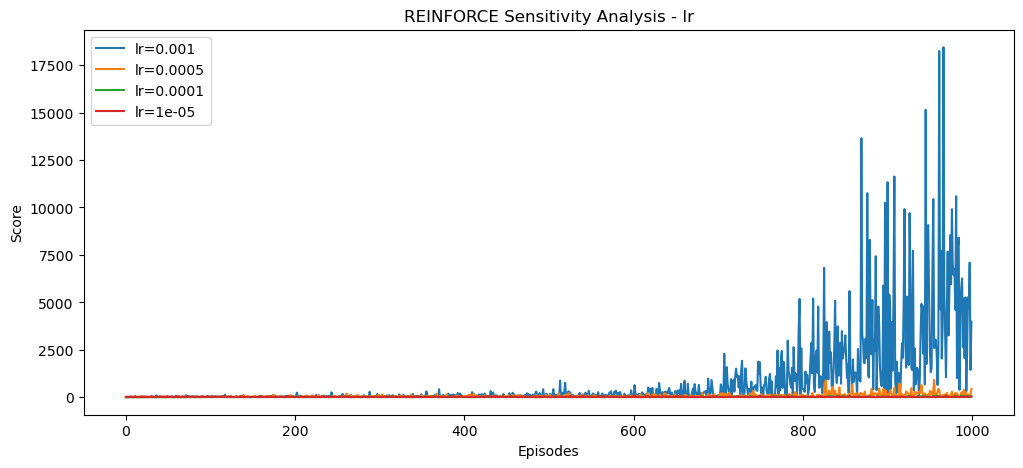

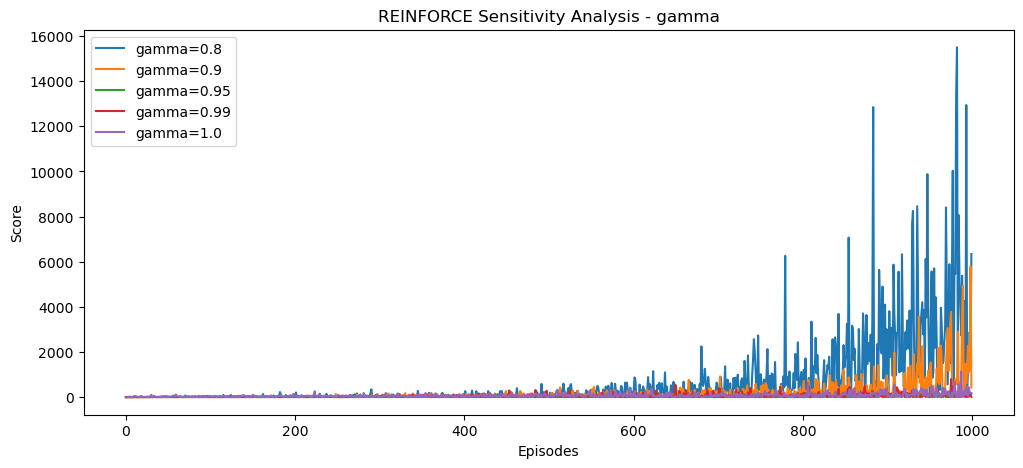

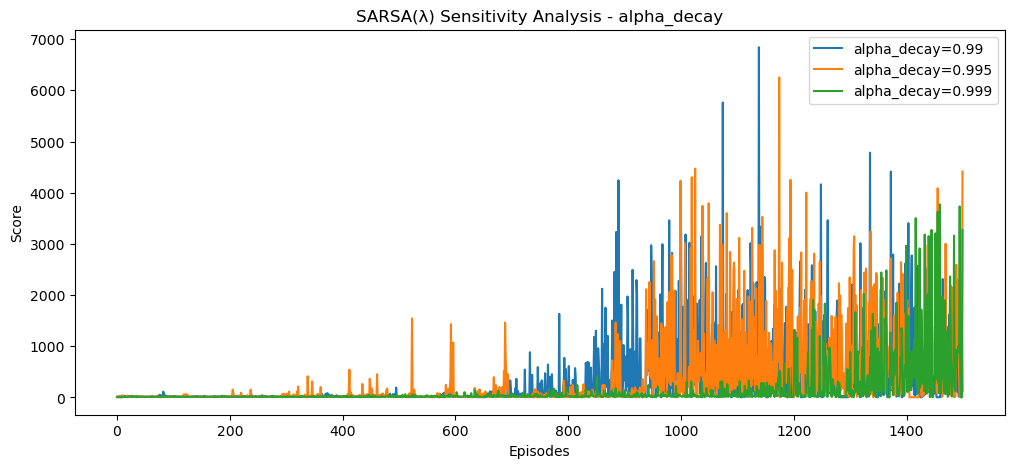

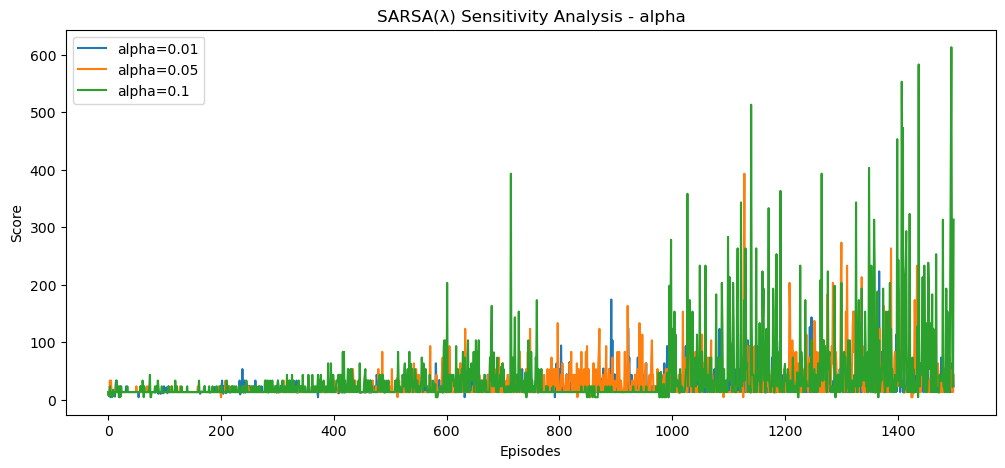

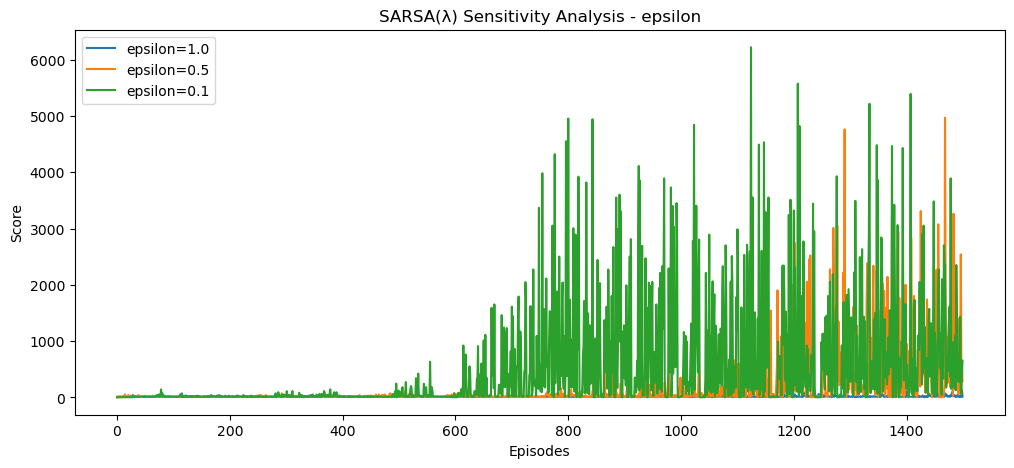

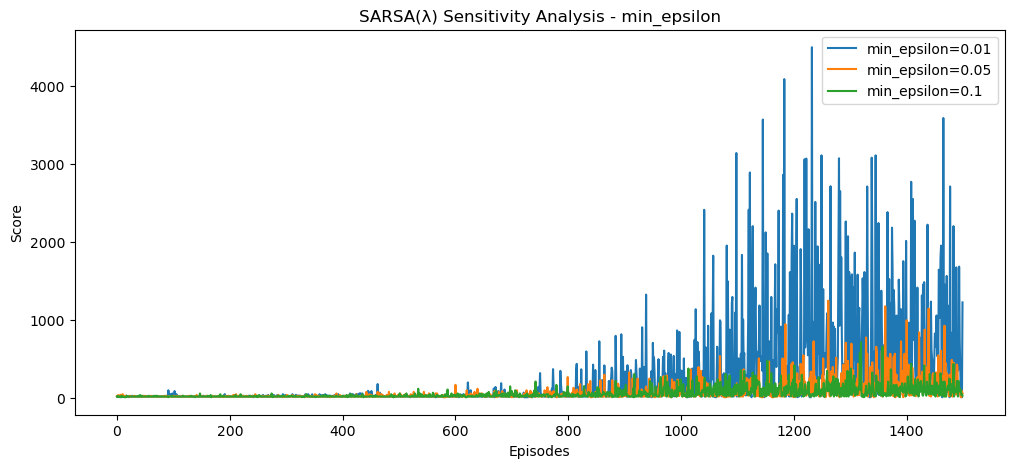

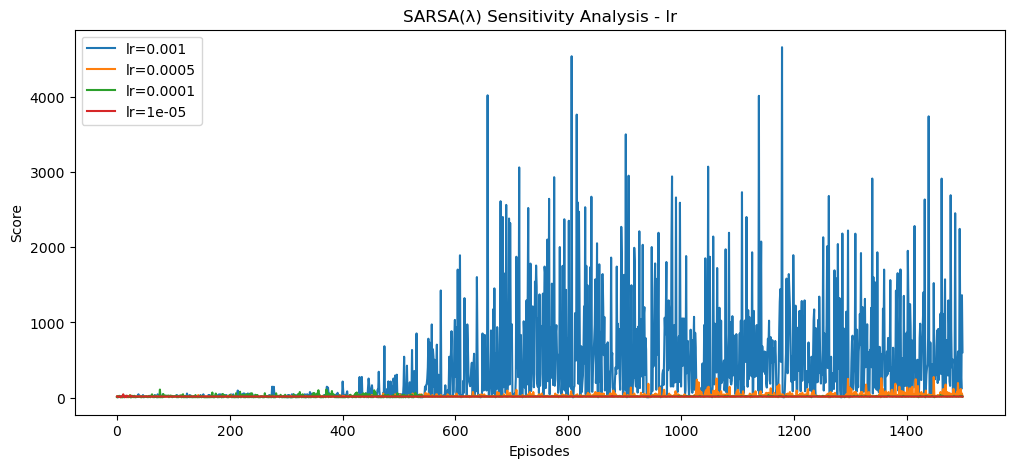

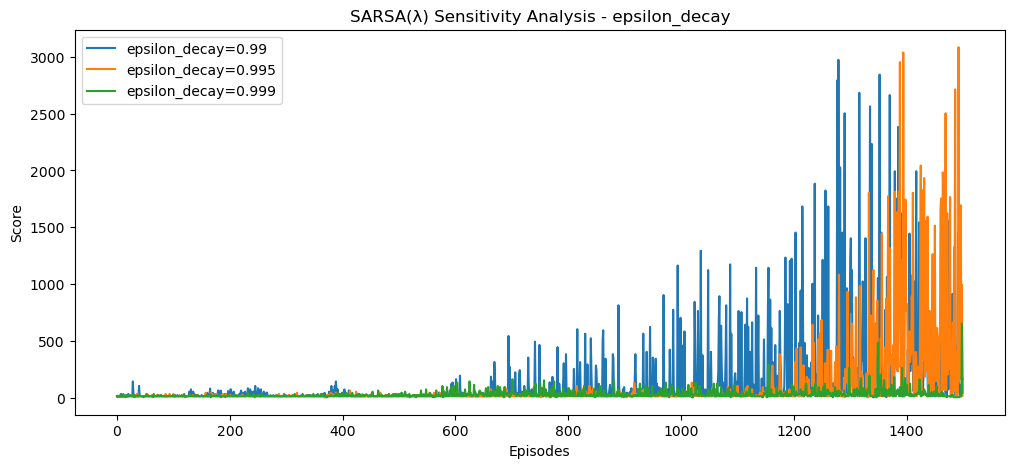

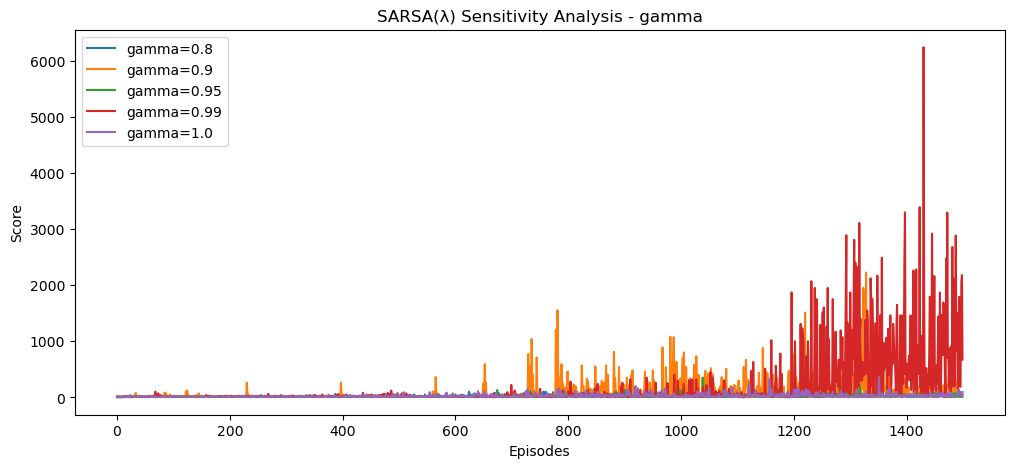

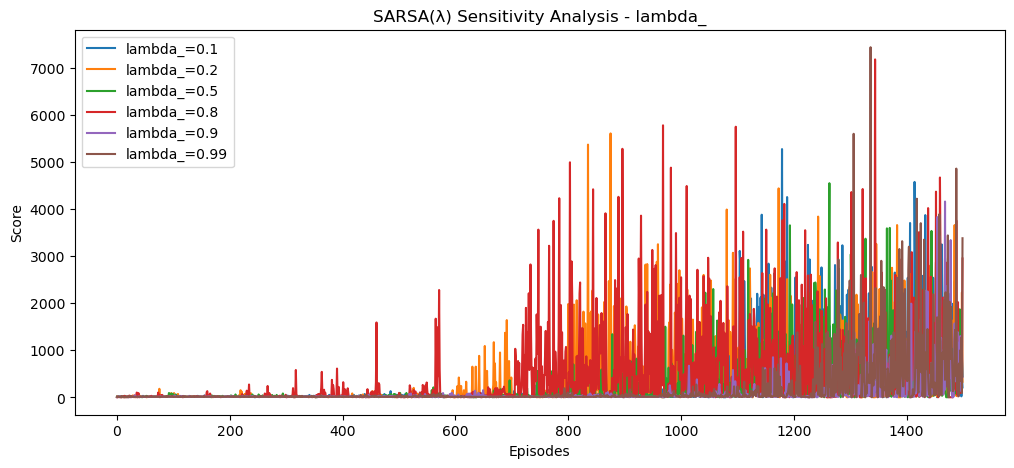

In [16]:
def plot_sensitivity_separate(results, title):
    """
    Plot training curves for different hyperparameters
    """
    for param_name in set(param for param, _ in results.keys()):
        plt.figure(figsize=(12, 5))
        for (param, value), scores in results.items():
            if param == param_name:
                plt.plot(scores, label=f"{param}={value}")

        plt.xlabel("Episodes")
        plt.ylabel("Score")
        plt.title(f"{title} - {param_name}")
        plt.legend()
        plt.show()

plot_sensitivity_separate(reinforce_results, "REINFORCE Sensitivity Analysis")
plot_sensitivity_separate(sarsa_results, "SARSA(λ) Sensitivity Analysis")


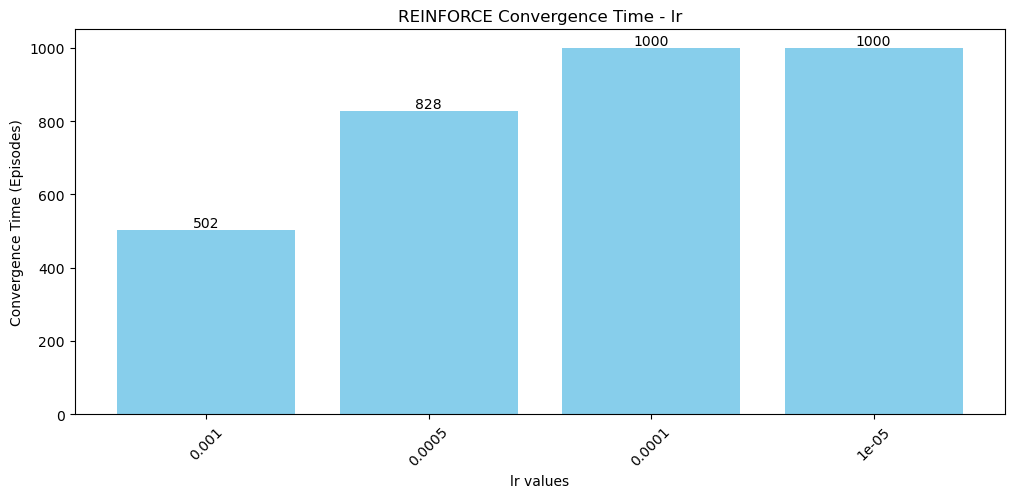

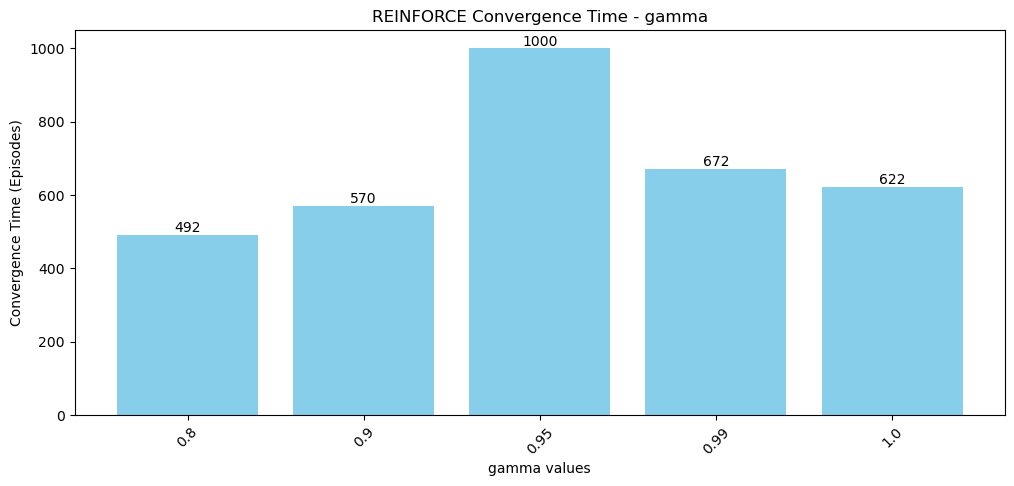

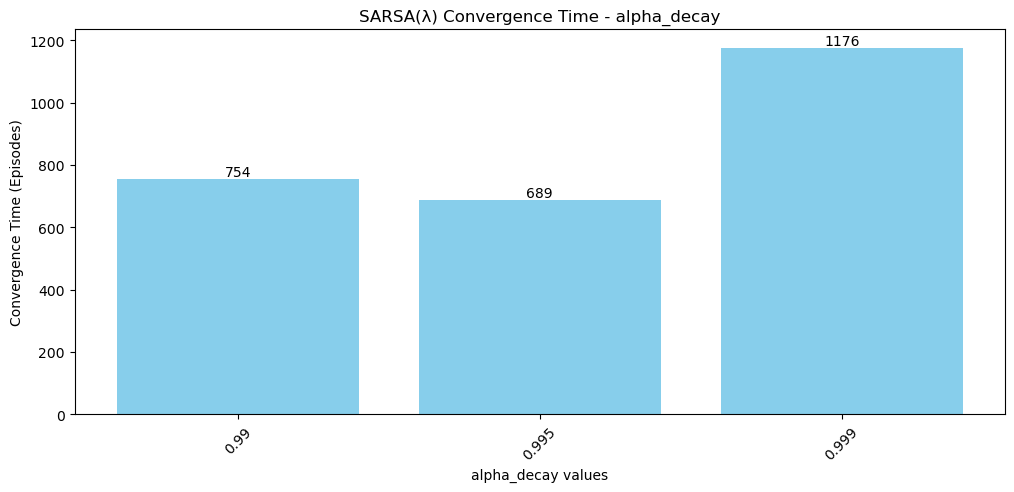

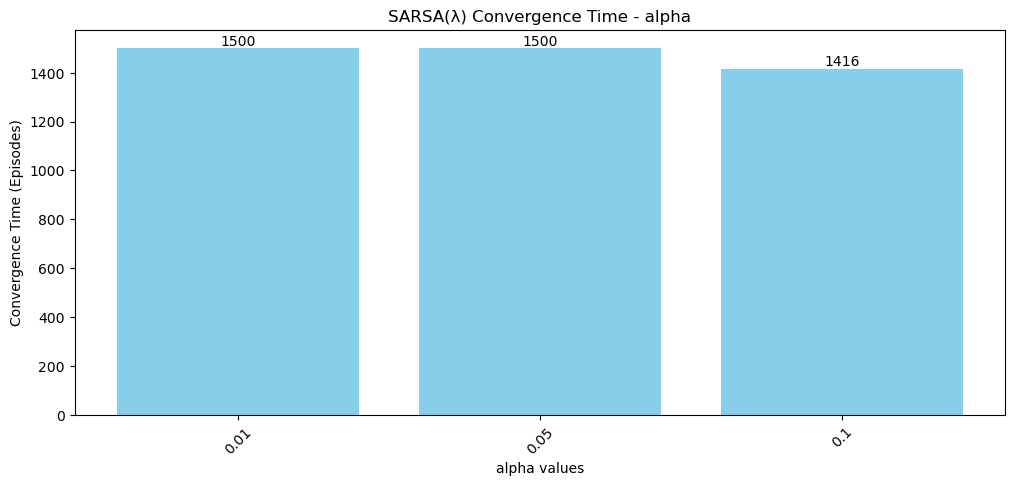

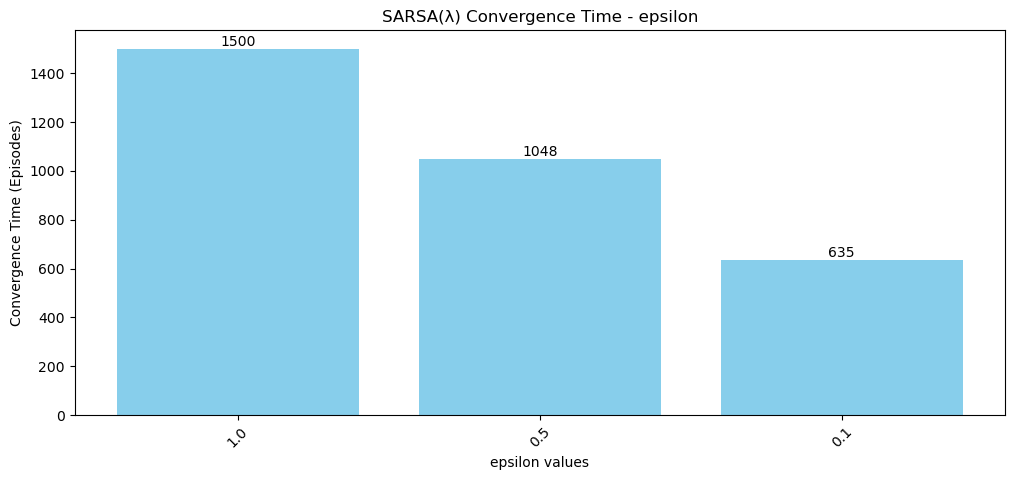

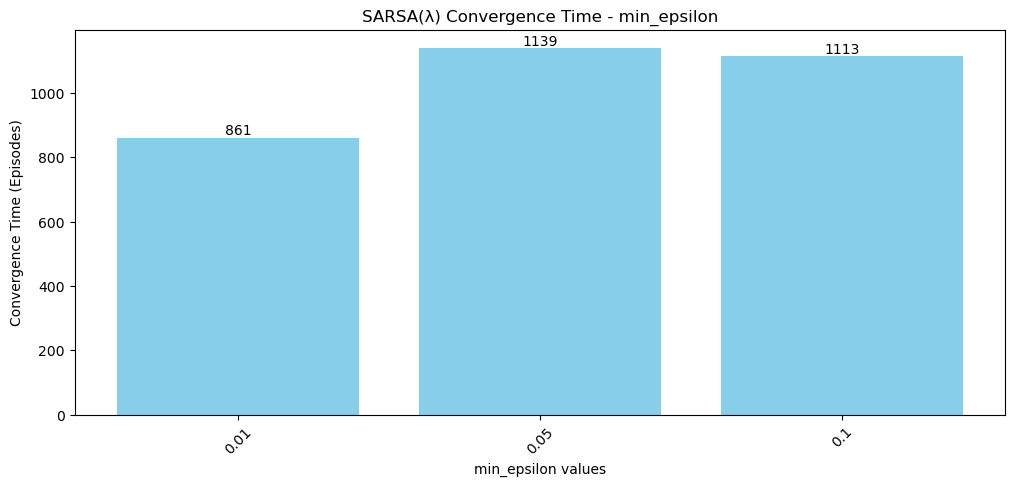

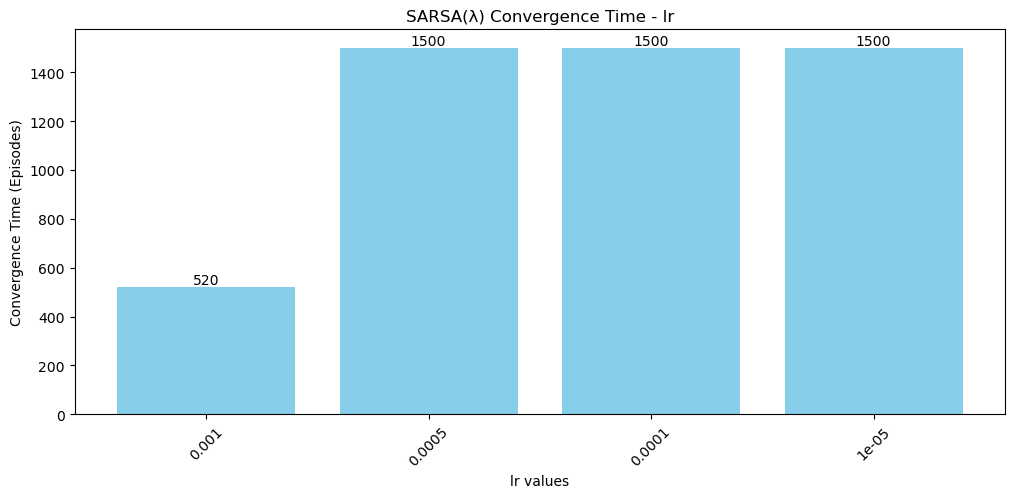

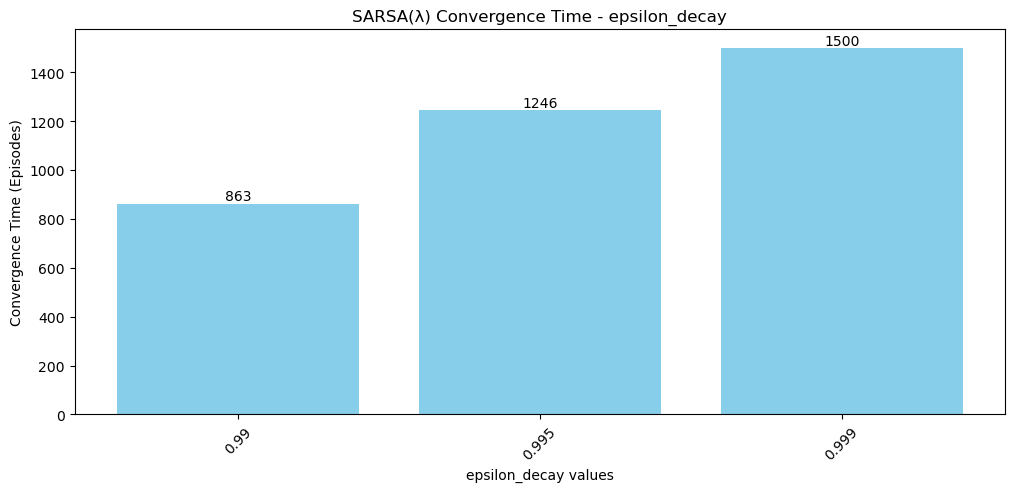

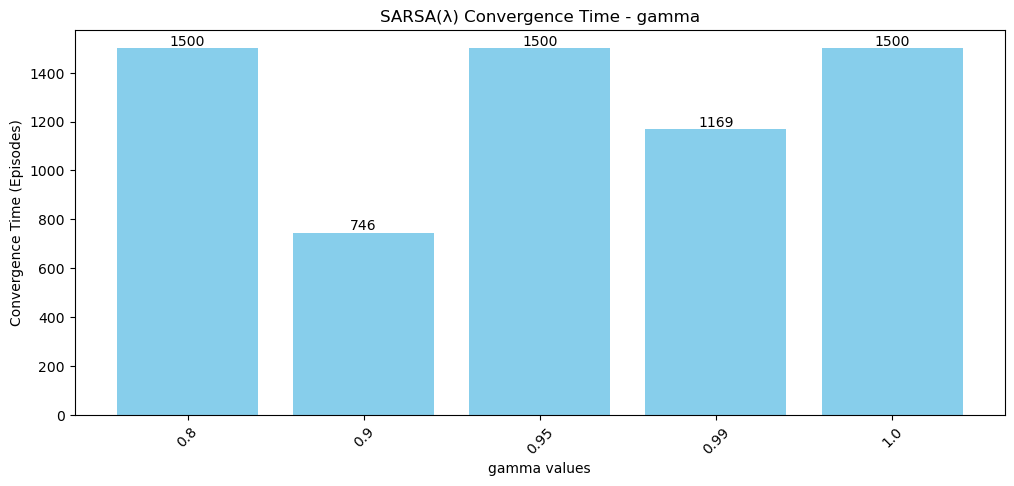

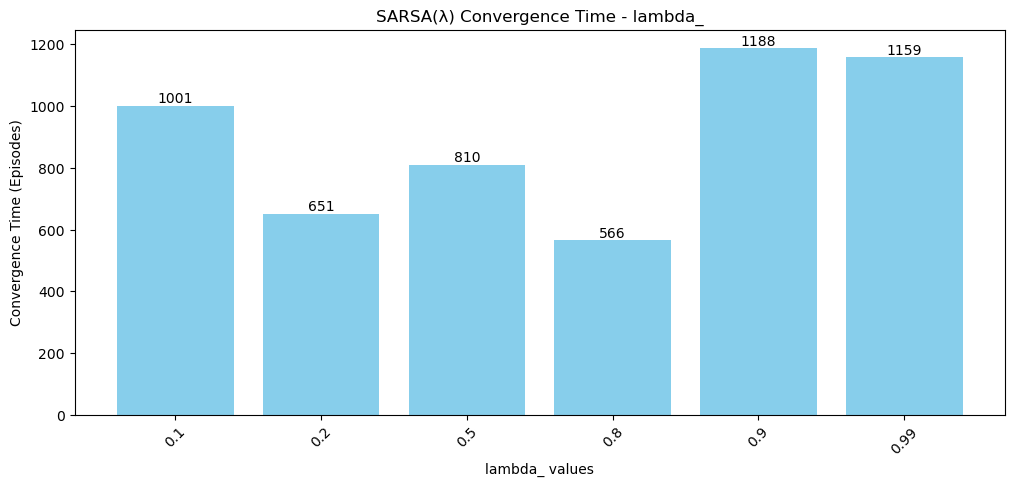

In [17]:
def plot_convergence_separate(convergence_times, title):
    """
    Plot convergence times for different hyperparameters
    """
    for param_name in set(param for param, _ in convergence_times.keys()):
        plt.figure(figsize=(12, 5))

        param_values = [value for (p, value) in convergence_times.keys() if p == param_name]
        convergence_values = [convergence_times[(param_name, value)] for value in param_values]

        bars = plt.bar([str(v) for v in param_values], convergence_values, color="skyblue")

        # Mark values
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.0f}', ha='center', va='bottom')

        plt.xlabel(f"{param_name} values")
        plt.ylabel("Convergence Time (Episodes)")
        plt.title(f"{title} - {param_name}")
        plt.xticks(rotation=45)
        plt.show()

plot_convergence_separate(reinforce_convergence_times, "REINFORCE Convergence Time")
plot_convergence_separate(sarsa_convergence_times, "SARSA(λ) Convergence Time")

<Figure size 1200x500 with 0 Axes>

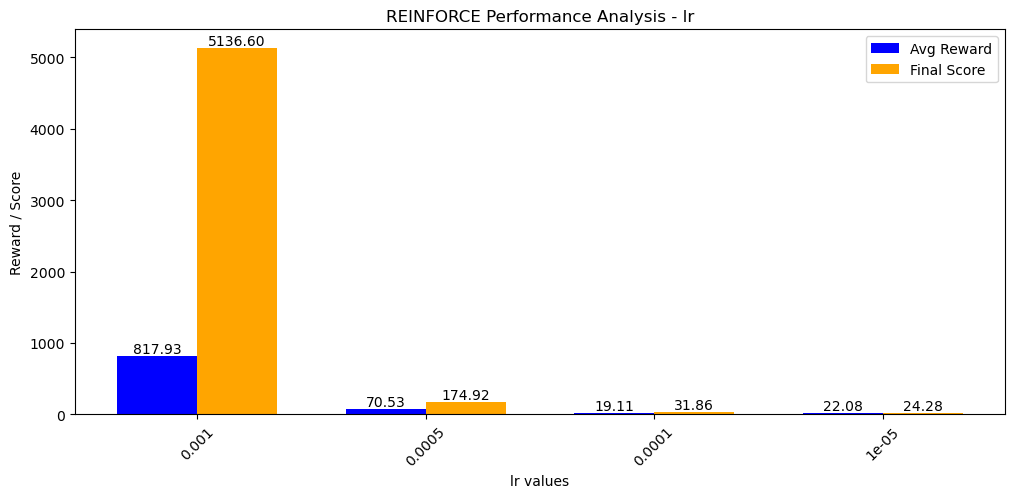

<Figure size 1200x500 with 0 Axes>

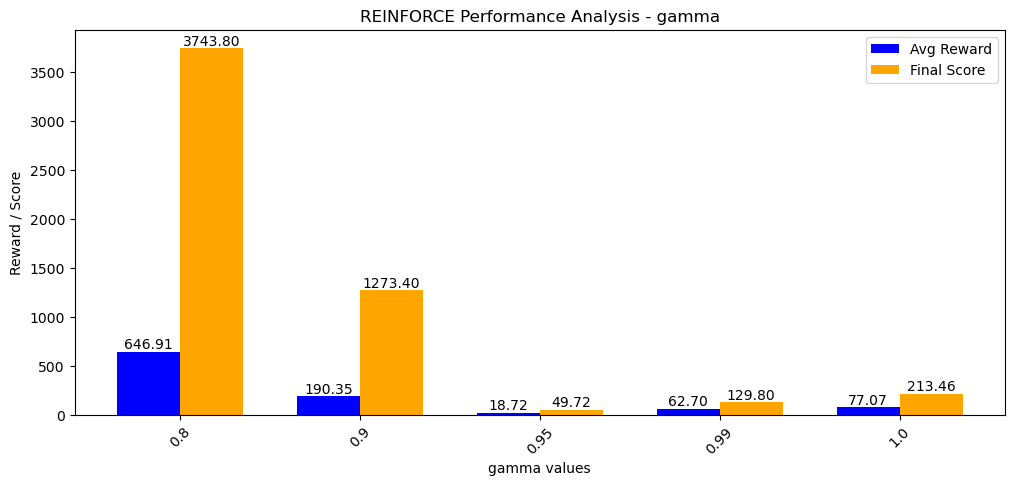

<Figure size 1200x500 with 0 Axes>

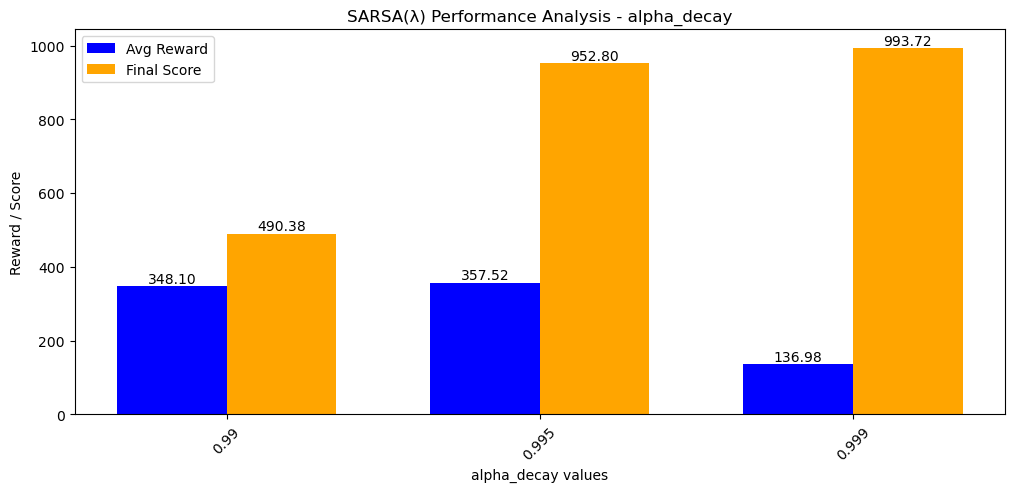

<Figure size 1200x500 with 0 Axes>

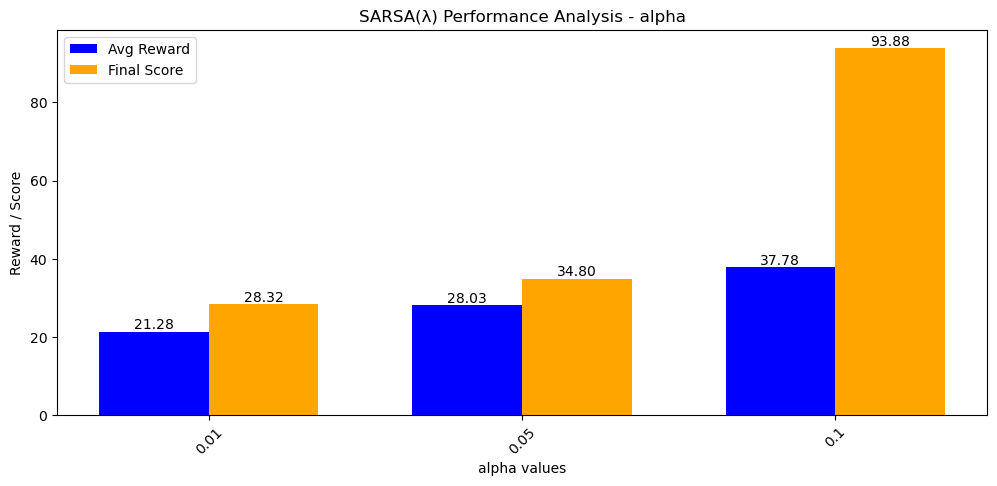

<Figure size 1200x500 with 0 Axes>

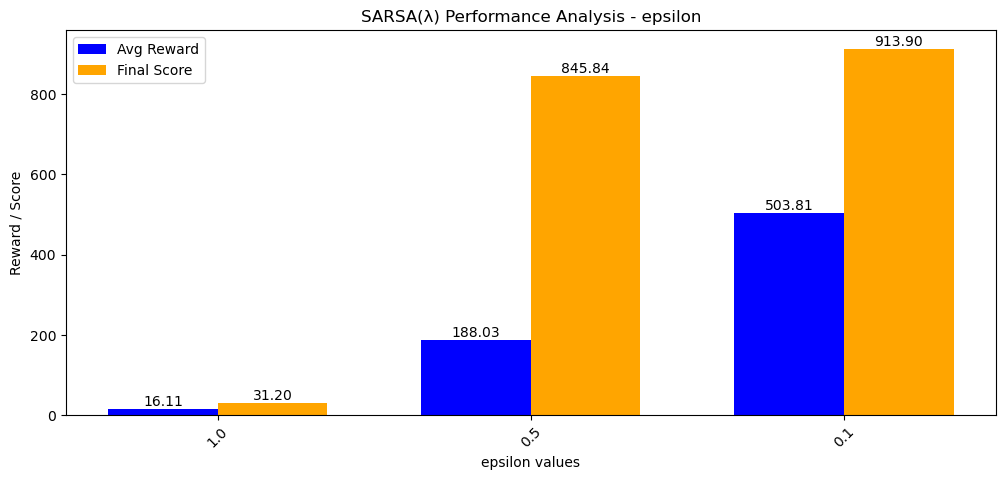

<Figure size 1200x500 with 0 Axes>

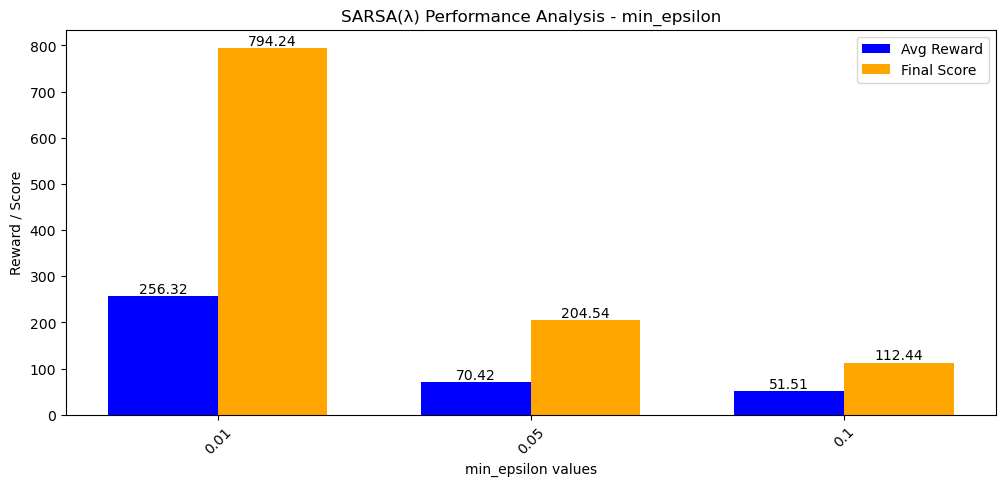

<Figure size 1200x500 with 0 Axes>

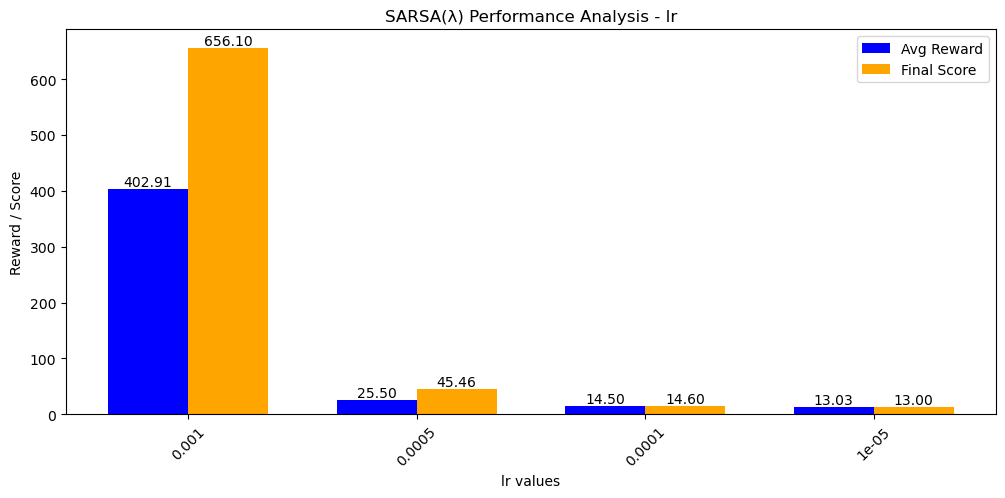

<Figure size 1200x500 with 0 Axes>

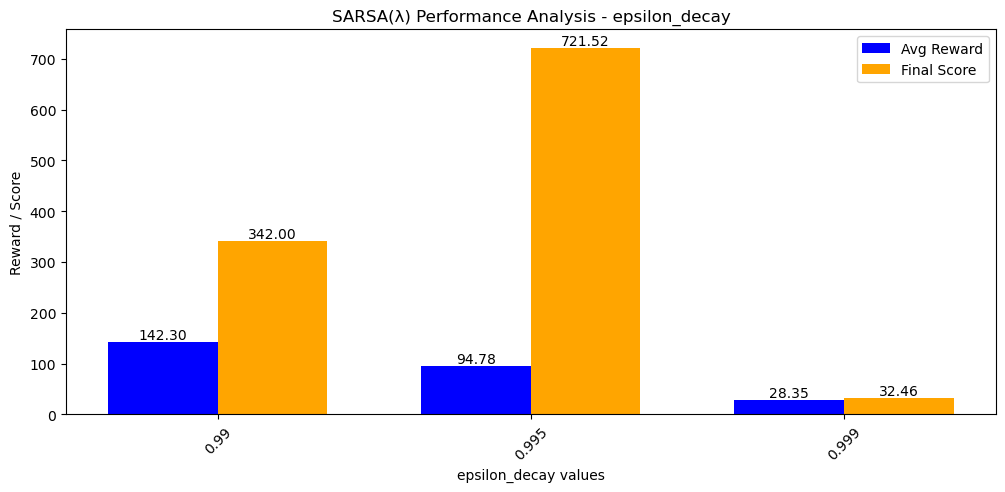

<Figure size 1200x500 with 0 Axes>

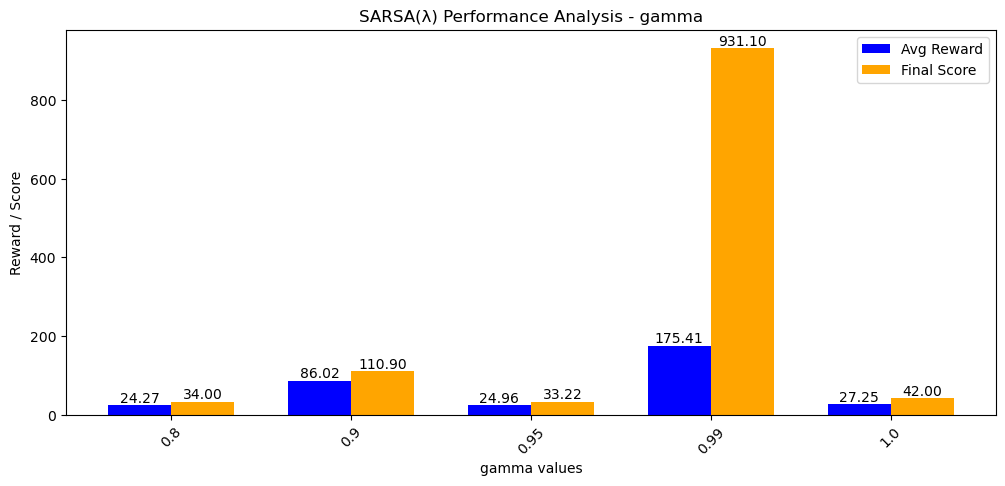

<Figure size 1200x500 with 0 Axes>

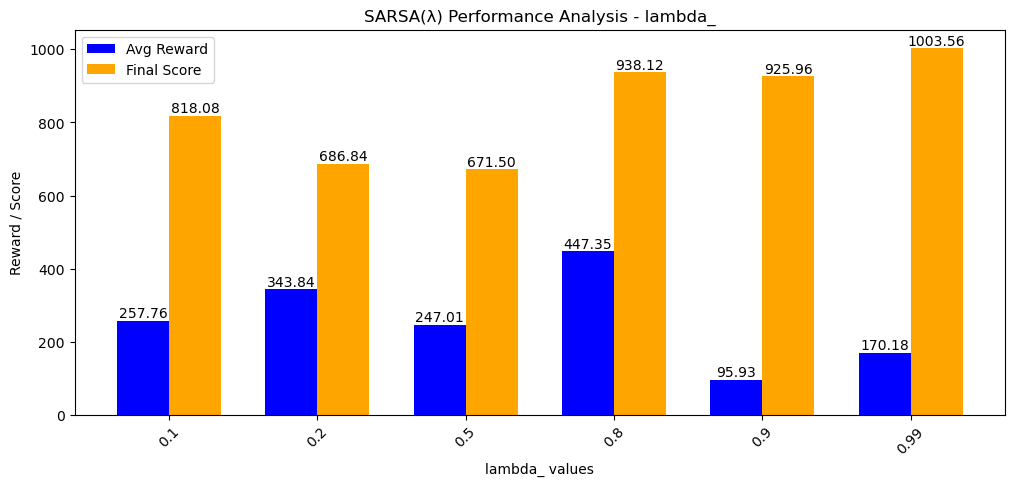

In [18]:
def plot_avg_rewards_and_scores(avg_rewards, avg_scores, title):
    """
    Plot average rewards and scores for different hyperparameters
    """
    for param_name in set(p for p, _ in avg_rewards.keys()):
        plt.figure(figsize=(12, 5))

        param_values = [value for (p, value) in avg_rewards.keys() if p == param_name]
        reward_values = [avg_rewards[(param_name, value)] for value in param_values]
        score_values = [avg_scores[(param_name, value)] for value in param_values]

        x = np.arange(len(param_values))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 5))
        bars1 = ax.bar(x - width/2, reward_values, width, label='Avg Reward', color='blue')
        bars2 = ax.bar(x + width/2, score_values, width, label='Final Score', color='orange')

        for bar in bars1:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

        for bar in bars2:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

        ax.set_xlabel(f"{param_name} values")
        ax.set_ylabel("Reward / Score")
        ax.set_title(f"{title} - {param_name}")
        ax.set_xticks(x)
        ax.set_xticklabels([str(v) for v in param_values], rotation=45)
        ax.legend()
        plt.show()

plot_avg_rewards_and_scores(reinforce_avg_rewards, reinforce_avg_scores, "REINFORCE Performance Analysis")
plot_avg_rewards_and_scores(sarsa_avg_rewards, sarsa_avg_scores, "SARSA(λ) Performance Analysis")

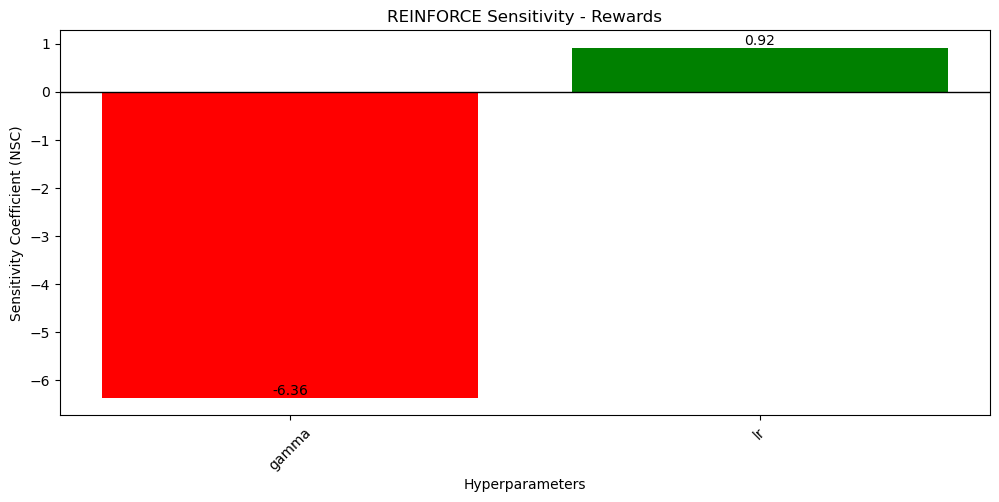

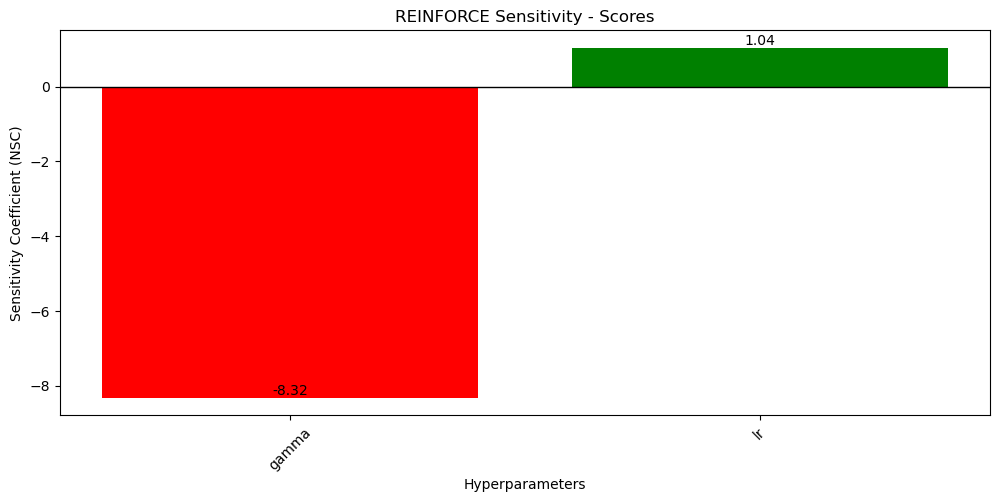

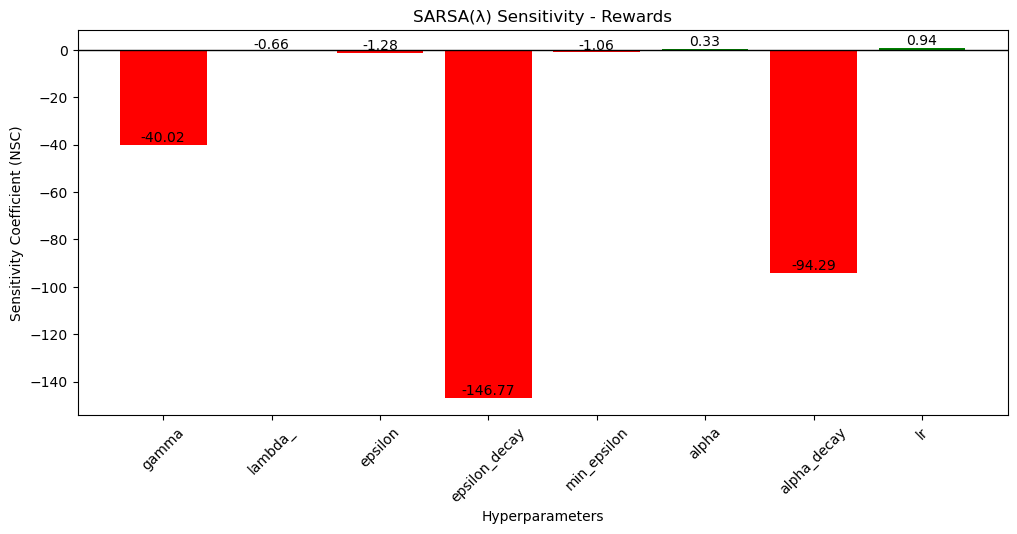

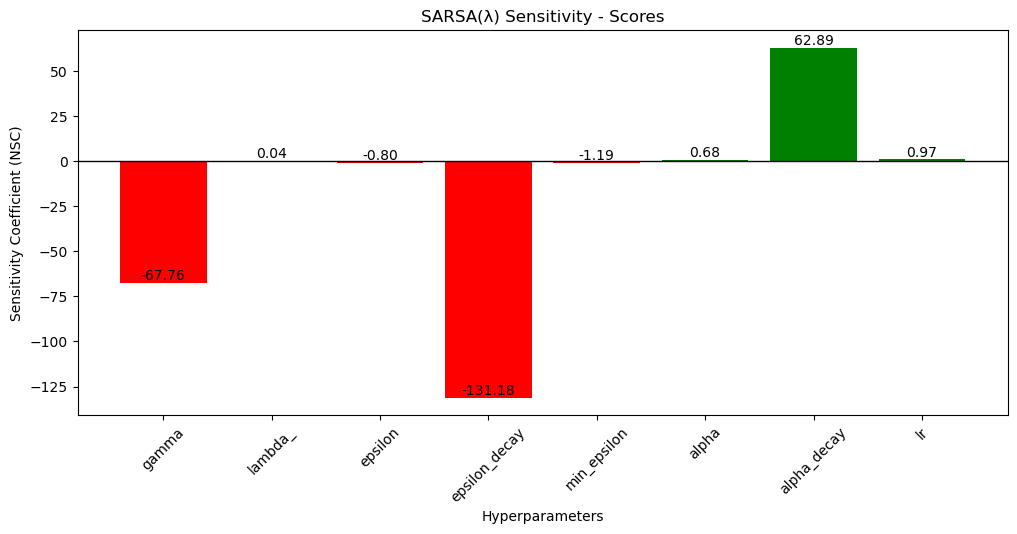

In [19]:
def plot_sensitivity_analysis(sensitivity_data, title):
    """
    Plot sensitivity analysis results
    """
    plt.figure(figsize=(12, 5))

    param_names = list(sensitivity_data.keys())
    sensitivity_values = list(sensitivity_data.values())

    bars = plt.bar(param_names, sensitivity_values, color=["red" if v < 0 else "green" for v in sensitivity_values])

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

    plt.xlabel("Hyperparameters")
    plt.ylabel("Sensitivity Coefficient (NSC)")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.axhline(0, color='black', linewidth=1)
    plt.show()

plot_sensitivity_analysis(sensitivity_rewards_reinforce, "REINFORCE Sensitivity - Rewards")
plot_sensitivity_analysis(sensitivity_scores_reinforce, "REINFORCE Sensitivity - Scores")

plot_sensitivity_analysis(sensitivity_rewards_sarsa, "SARSA(λ) Sensitivity - Rewards")
plot_sensitivity_analysis(sensitivity_scores_sarsa, "SARSA(λ) Sensitivity - Scores")

## Agents comparison

Let set the optimal parameters for both agents, and run them with the same epochs.

In [14]:
env = gym.make('TextFlappyBird-v0', height = 15, width = 20, pipe_gap = 4)
policy_R = REINFORCE_Agent().to(device)
optimizer_R = optim.Adam(policy_R.parameters(), lr=0.001, eps=1e-4, weight_decay=1e-5)

n_episodes = 750
reinforce_scores, reinforce_state_values = reinforce_training(n_episodes=n_episodes, policy=policy_R, optimizer=optimizer_R, gamma=0.95)

Training REINFORCE:  34%|███▍      | 254/750 [00:02<00:05, 87.65it/s] 

Episode 250 	Recent Smoothed Score: 48.60


Training REINFORCE:  67%|██████▋   | 502/750 [00:10<00:17, 13.86it/s]

Episode 500 	Recent Smoothed Score: 278.42


Training REINFORCE: 100%|██████████| 750/750 [04:25<00:00,  2.83it/s]

Episode 750 	Recent Smoothed Score: 8965.60


In [18]:
n_episodes = 750

policy_S = Sarsa_Policy().to(device)

params_sarsa = {
    "action_size": 2,
    "alpha": 0.1,
    "alpha_decay": 0.999,
    "gamma": 0.99,
    "lambda_": 0.99,
    "epsilon": 0.1,
    "epsilon_decay": 0.999,
    "min_epsilon": 0.01
}

optimizer_S = optim.Adam(policy_S.parameters(), lr=0.001, eps=1e-4, weight_decay=1e-5)

sarsa_scores, sarsa_state_values = sarsa_training(n_episodes, policy_S, optimizer_S, params_sarsa)

Training SARSA(λ):  34%|███▍      | 255/750 [00:03<00:08, 58.77it/s] 

Episode 250 	Recent Smoothed Score: 71.68


Training SARSA(λ):  67%|██████▋   | 501/750 [00:47<00:46,  5.31it/s]

Episode 500 	Recent Smoothed Score: 609.94


Training SARSA(λ): 100%|██████████| 750/750 [01:47<00:00,  7.00it/s]

Episode 750 	Recent Smoothed Score: 917.78


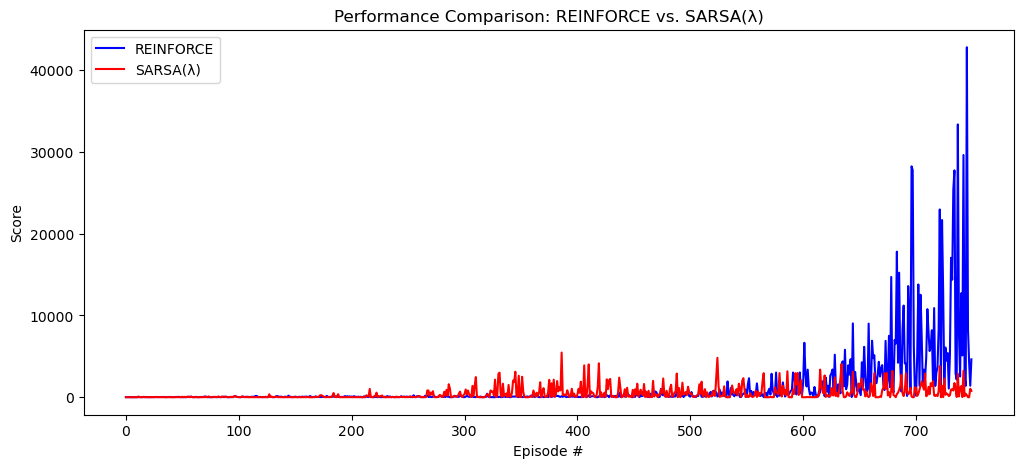

In [19]:
# Scores Comparation
# ------------------------
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(reinforce_scores)), reinforce_scores, label="REINFORCE", color="blue")
plt.plot(np.arange(len(sarsa_scores)), sarsa_scores, label="SARSA(λ)", color="red")

plt.xlabel("Episode #")
plt.ylabel("Score")
plt.title("Performance Comparison: REINFORCE vs. SARSA(λ)")
plt.legend()
plt.show()

In [20]:
# Compute convergence times
reinforce_convergence_time = compute_convergence_time(reinforce_scores, 200)
sarsa_convergence_time = compute_convergence_time(sarsa_scores, 200)

# Compute average scores
reinforce_avg_score = np.mean(reinforce_scores[-50:])
sarsa_avg_score = np.mean(sarsa_scores[-50:])

# Compute average rewards
reinforce_avg_reward = np.mean(reinforce_scores)
sarsa_avg_reward = np.mean(sarsa_scores)

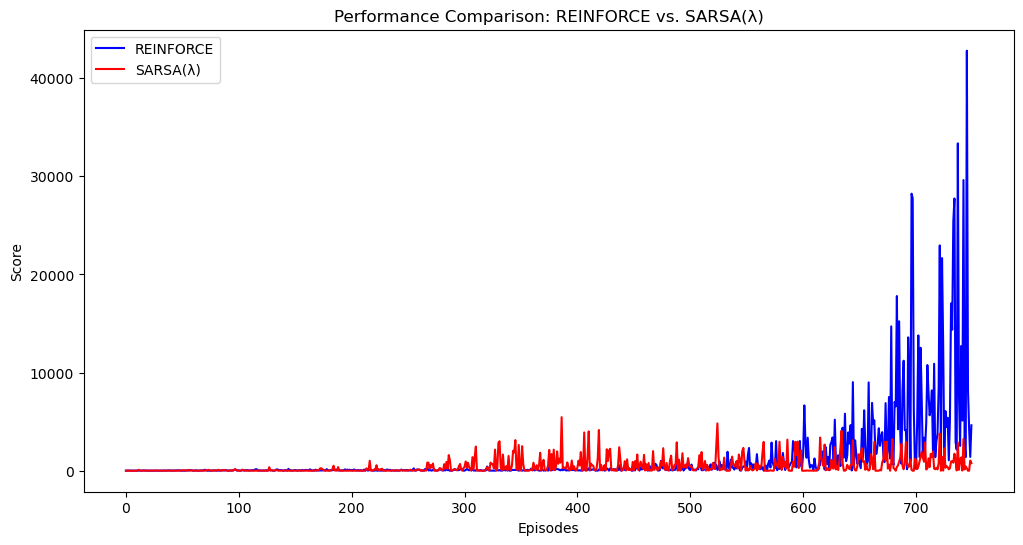

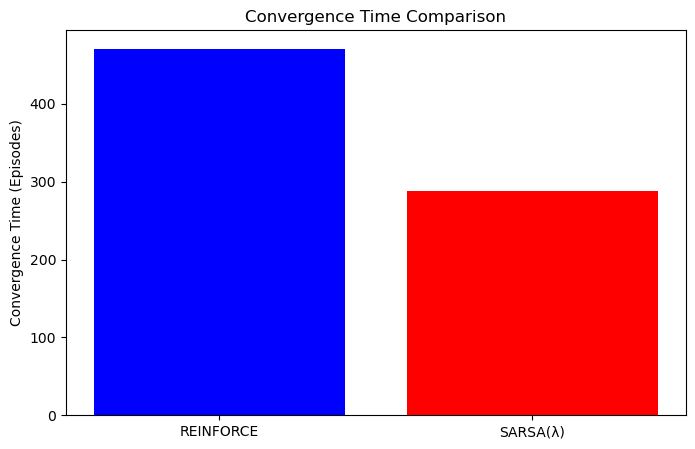

In [21]:
# Plot training performance comparison
plt.figure(figsize=(12, 6))
plt.plot(reinforce_scores, label="REINFORCE", color="blue")
plt.plot(sarsa_scores, label="SARSA(λ)", color="red")
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.title("Performance Comparison: REINFORCE vs. SARSA(λ)")
plt.legend()
plt.show()

# Plot convergence times
plt.figure(figsize=(8, 5))
plt.bar(["REINFORCE", "SARSA(λ)"], [reinforce_convergence_time, sarsa_convergence_time], color=["blue", "red"])
plt.ylabel("Convergence Time (Episodes)")
plt.title("Convergence Time Comparison")
plt.show()

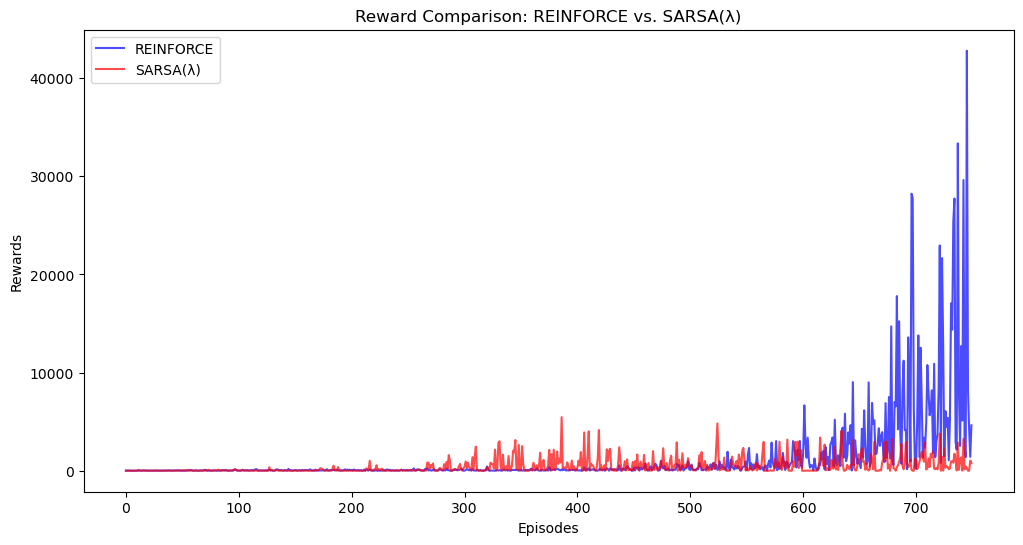

In [22]:
# Compute rewards (assuming rewards are episode scores)
reinforce_rewards = np.array(reinforce_scores)
sarsa_rewards = np.array(sarsa_scores)

# Plot rewards comparison
plt.figure(figsize=(12, 6))
plt.plot(reinforce_rewards, label="REINFORCE", color="blue", alpha=0.7)
plt.plot(sarsa_rewards, label="SARSA(λ)", color="red", alpha=0.7)
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.title("Reward Comparison: REINFORCE vs. SARSA(λ)")
plt.legend()
plt.show()

## Plot State-Value Function


In [23]:
def plot_state_values(state_values, title):
    """
    Generate a 2D heatmap and 3D surface plot for state-value function.
    """
    states = list(state_values.keys())
    
    # Make sure each corresponding value is a scalar
    values = [np.mean(v) if isinstance(v, (list, np.ndarray)) else v for v in state_values.values()]

    x = np.array([s[0] for s in states])  # Extract state components
    y = np.array([s[1] for s in states])
    z = np.array(values)

    fig = plt.figure(figsize=(12, 5))

    # 2D Heatmap
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, c=z, cmap="coolwarm", s=50)
    plt.colorbar(label="State Value")
    plt.xlabel("State Dimension 1")
    plt.ylabel("State Dimension 2")
    plt.title(f"2D State-Value Heatmap: {title}")

    # 3D Surface Plot
    ax = fig.add_subplot(1, 2, 2, projection="3d")
    ax.scatter(x, y, z, c=z, cmap="coolwarm")
    ax.set_xlabel("State Dimension 1")
    ax.set_ylabel("State Dimension 2")
    ax.set_zlabel("State Value")
    ax.set_title(f"3D State-Value Surface: {title}")

    plt.show()

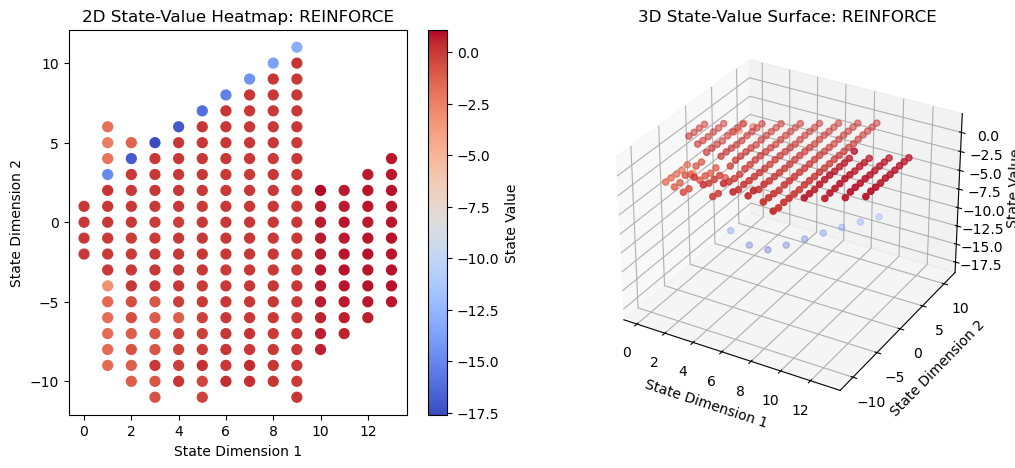

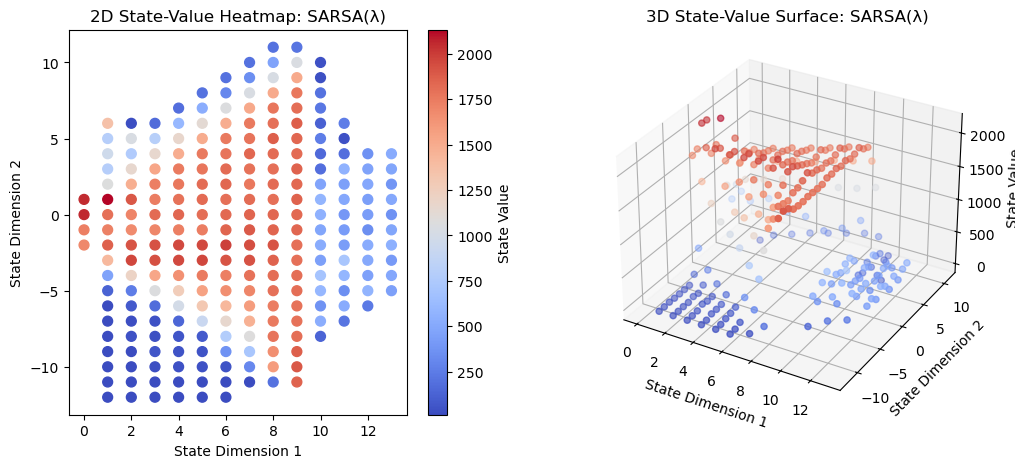

In [24]:
# Plot State-Value Functions
plot_state_values(reinforce_state_values, "REINFORCE")
plot_state_values(sarsa_state_values, "SARSA(λ)")

In [25]:
# Print final results
print("\n===== AGENT COMPARISON RESULTS =====")
print(f"Convergence Time: REINFORCE = {reinforce_convergence_time}, SARSA(λ) = {sarsa_convergence_time}")
print(f"Avg Reward: REINFORCE = {reinforce_avg_reward:.2f}, SARSA(λ) = {sarsa_avg_reward:.2f}")
print(f"Avg Score (last 50 episodes): REINFORCE = {reinforce_avg_score:.2f}, SARSA(λ) = {sarsa_avg_score:.2f}")


===== AGENT COMPARISON RESULTS =====
Convergence Time: REINFORCE = 471, SARSA(λ) = 288
Avg Reward: REINFORCE = 1229.82, SARSA(λ) = 459.82
Avg Score (last 50 episodes): REINFORCE = 8965.60, SARSA(λ) = 917.78


In [29]:
env.close()

In [ ]:
env_new_1 = gym.make('TextFlappyBird-v0', height=20, width=25, pipe_gap=6)

# policy_R = REINFORCE_Agent().to(device)
# optimizer_R = optim.Adam(policy_R.parameters(), lr=0.001, eps=1e-4, weight_decay=1e-5)

n_episodes = 750
reinforce_scores_new_env, reinforce_state_values_new_env = reinforce_training(n_episodes=n_episodes, policy=policy_R, optimizer=optimizer_R, gamma=0.95)

env_new_1.close()

Training REINFORCE:  34%|███▎      | 253/750 [00:02<00:06, 79.48it/s] 

Episode 250 	Recent Smoothed Score: 51.62


Training REINFORCE:  67%|██████▋   | 500/750 [00:49<05:45,  1.38s/it]

Episode 500 	Recent Smoothed Score: 1726.20


Training REINFORCE:  86%|████████▋ | 648/750 [16:31<1:11:14, 41.90s/it]